# Get multibolid data



In [1]:
from MLABvo.Bolidozor import Bolidozor
import json
import datetime
import numpy as np
import scipy.signal
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib import dates
import sys
sys.path.append("..") 
import recviewer
import dateutil.parser

%matplotlib inline 

# Inicializace bolidozoru

Funkce ```Bolidozor.getMultibolid``` jako jediný parametr bere id skupiny, které lze zjistit například zde: http://rtbolidozor.astro.cz/multibolid/

ID stanic k 2017.09.18

station_id station_name

23 ZVPP-R6

25 OBSUPICE-R6

26 CIIRC-R1

27 DDMTREBIC-R3

29 SVAKOV-R12

30 VALMEZ-R1

31 NACHODSKO-R5

32 HFN-R1

In [90]:
bz = Bolidozor()
stations = bz.setStation(29)
bolids = bz.getMeteor(date_from = datetime.datetime(2017,9,1,18), date_to = datetime.datetime(2017,9,15,10,59), min_duration = 4)
print('Počet detekcí ve skupině je',len(bolids.result))

Počet detekcí ve skupině je 137


Získaná data z MLABvo jsou k dispozici v ```Bolidozor.getMultibolid.result```.

Následující buňka ukazuje, jak lze procházet záznamy po jednom.

**Výsledek obsahuje následující informace**

In [63]:
print(list(bolids.result[0].keys()))
print("")
print(bolids.result[0])

['url_file_js9', 'url_file', 'id', 'peak_f', 'duration', 'filename', 'mag', 'id_observer', 'obstime', 'id_server', 'noise', 'filename_original', 'filename_raw', 'filepath', 'url_station', 'file_status', 'url_file_raw']

{'url_file_js9': 'http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/16/09/20170916095942066_SVAKOV-R12_met.fits', 'url_file': 'http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/16/09/20170916095942066_SVAKOV-R12_met.fits', 'id': 23695314, 'peak_f': 26497.6, 'duration': 1.87733, 'filename': '20170916095942066_SVAKOV-R12_met.fits', 'mag': 3.04302, 'id_observer': 29, 'obstime': '2017-09-16T09:59:47', 'id_server': 1, 'noise': 1.26016, 'filename_original': '20170916095942066_SVAKOV-R12_met.fits', 'filename_raw': '20170916095942066_SVAKOV-R12_raws.fits', 'filepath': '/storage/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/16/09', 'url_station': 'http://api.vo.astro.cz/bolidozor/getStation/?id=29', 'file_status': 'onl

# Kalibrace času

tato funkce projde RAW soubory a snaží se v nich vyhledat GPS značku. 

Výstupem této funkce je ```dictionary```, který obsahuje informace o času na začátku souboru, času konce souboru a prvního vzorku s GPS značkou ze systémového času stanice. Tyto samé časy vrací taktéž oproti GPS času.


In [64]:
def timeCalibration(raw_file, sigma = 18, debug = True):
    calibration_data = {}
    hdulist = fits.open(raw_file)
    met_data = np.abs(np.ravel(hdulist[0].data))
    clip_val = np.std(met_data)*sigma
    plt.axhline(y=clip_val, color='red')
    max_val = np.max(met_data)
    for i, point in enumerate(met_data):
        if point > clip_val:
            plt.axvline(x=i, color='red')
            ten_sec = 10/(hdulist[0].header['CDELT2']/2/1000.0)
            if debug: plt.axvline(x=i+ten_sec, color='green')
            break
    file_length = hdulist[0].header['NAXIS2']*hdulist[0].header['CDELT2']/1000.0
    time_firstGPS = i/2*hdulist[0].header['CDELT2']/1000.0
    DATE_OBS = datetime.datetime.strptime(hdulist[0].header['DATE-OBS'], "%Y-%m-%dT%H:%M:%S" )
    
    gps = (DATE_OBS-datetime.timedelta(seconds=file_length-time_firstGPS)).timestamp()
    round_gps = round(gps/10.0)*10
    correction = datetime.timedelta(seconds=round_gps-gps)

    calibration_data['sys_correction'] = correction
    
    calibration_data['sys_file_beg'] = DATE_OBS-datetime.timedelta(seconds=file_length)
    calibration_data['sys_file_end'] = DATE_OBS
    calibration_data['sys_1st_GPS'] = DATE_OBS-datetime.timedelta(seconds=file_length-time_firstGPS)
    calibration_data['sys_error'] = DATE_OBS-datetime.timedelta(seconds=file_length-time_firstGPS)
    
    calibration_data['cor_file_beg'] = DATE_OBS-datetime.timedelta(seconds=file_length)+correction
    calibration_data['cor_file_end'] = DATE_OBS+correction
    calibration_data['cor_1st_GPS'] = DATE_OBS-datetime.timedelta(seconds=file_length-time_firstGPS)+correction
    calibration_data['cor_error'] = correction
    
    if debug:
        file_length = hdulist[0].header['NAXIS2']*hdulist[0].header['CDELT2']/1000.0
        time_firstGPS = i/2*hdulist[0].header['CDELT2']/1000.0
        DATE_OBS = datetime.datetime.strptime(hdulist[0].header['DATE-OBS'], "%Y-%m-%dT%H:%M:%S" )
        print("Zpracovavam soubor:", raw_file)
        print('delka zaznamu          :', file_length, "s")
        print('cas prvni vzorku s GPS :', time_firstGPS, "s")
        print('cas 1. GPS a konec     :', file_length - time_firstGPS, "s")
        print('SysCas ukladani souboru:', calibration_data['sys_file_end'], "s")
        print('SysCas zacatku souboru :', calibration_data['sys_file_beg'])
        print('SysCas 1. GPS znacky   :', calibration_data['sys_1st_GPS'])
        print('Korekce systémoveho čas:', correction)
        print('CorCas ukladani souboru:', calibration_data['cor_file_end'], "s")
        print('CorCas zacatku souboru :', calibration_data['cor_file_beg'])
        print('CorCas 1. GPS znacky   :', calibration_data['cor_1st_GPS'])
        plt.plot(met_data)
        plt.show()
    return calibration_data
        

Tato smyčka projde všechny soubory a použije na nich funkci pro kalibraci času. Výstup přidá do původní proměnné pod klíčem ```time_calib```.

0 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/15/10/20170915105013392_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/15/10/20170915105013392_SVAKOV-R12_raws.fits
delka zaznamu          : 10.199992847329998 s
cas prvni vzorku s GPS : 1.0516045031799999 s
cas 1. GPS a konec     : 9.148388344149998 s
SysCas ukladani souboru: 2017-09-15 10:50:13 s
SysCas zacatku souboru : 2017-09-15 10:50:02.800007
SysCas 1. GPS znacky   : 2017-09-15 10:50:03.851612
Korekce systémoveho čas: -1 day, 23:59:56.148388
CorCas ukladani souboru: 2017-09-15 10:50:09.148388 s
CorCas zacatku souboru : 2017-09-15 10:49:58.948395
CorCas 1. GPS znacky   : 2017-09-15 10:50:00


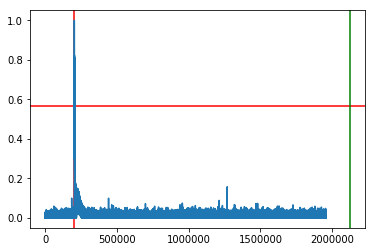

-1 day, 23:59:56.148388
1 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/15/10/20170915101059387_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/15/10/20170915101059387_SVAKOV-R12_raws.fits
delka zaznamu          : 22.600007232 s
cas prvni vzorku s GPS : 6.39348121258 s
cas 1. GPS a konec     : 16.20652601942 s
SysCas ukladani souboru: 2017-09-15 10:10:59 s
SysCas zacatku souboru : 2017-09-15 10:10:36.399993
SysCas 1. GPS znacky   : 2017-09-15 10:10:42.793474
Korekce systémoveho čas: -1 day, 23:59:57.206526
CorCas ukladani souboru: 2017-09-15 10:10:56.206526 s
CorCas zacatku souboru : 2017-09-15 10:10:33.606519
CorCas 1. GPS znacky   : 2017-09-15 10:10:40


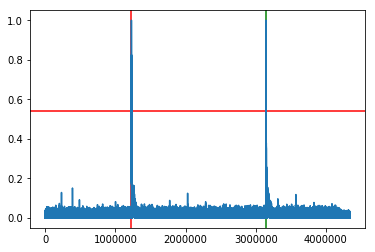

-1 day, 23:59:57.206526
2 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/15/08/20170915082551547_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/15/08/20170915082551547_SVAKOV-R12_raws.fits
delka zaznamu          : 9.600003072 s
cas prvni vzorku s GPS : 7.38331486266 s
cas 1. GPS a konec     : 2.21668820934 s
SysCas ukladani souboru: 2017-09-15 08:25:51 s
SysCas zacatku souboru : 2017-09-15 08:25:41.399997
SysCas 1. GPS znacky   : 2017-09-15 08:25:48.783312
Korekce systémoveho čas: 0:00:01.216688
CorCas ukladani souboru: 2017-09-15 08:25:52.216688 s
CorCas zacatku souboru : 2017-09-15 08:25:42.616685
CorCas 1. GPS znacky   : 2017-09-15 08:25:50


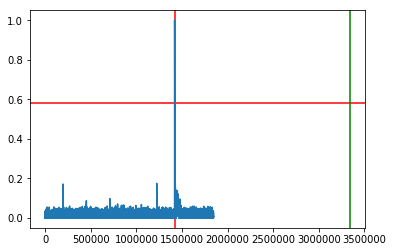

0:00:01.216688
3 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/15/06/20170915065215589_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/15/06/20170915065215589_SVAKOV-R12_raws.fits
delka zaznamu          : 50.400016128 s
cas prvni vzorku s GPS : 6.498252079439999 s
cas 1. GPS a konec     : 43.90176404856 s
SysCas ukladani souboru: 2017-09-15 06:52:15 s
SysCas zacatku souboru : 2017-09-15 06:51:24.599984
SysCas 1. GPS znacky   : 2017-09-15 06:51:31.098236
Korekce systémoveho čas: -1 day, 23:59:58.901764
CorCas ukladani souboru: 2017-09-15 06:52:13.901764 s
CorCas zacatku souboru : 2017-09-15 06:51:23.501748
CorCas 1. GPS znacky   : 2017-09-15 06:51:30


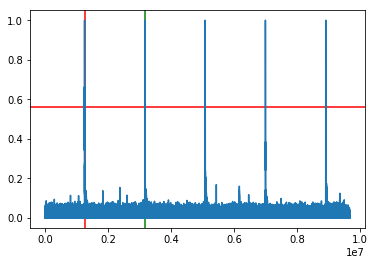

-1 day, 23:59:58.901764
4 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/15/05/20170915051712421_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/15/05/20170915051712421_SVAKOV-R12_raws.fits
delka zaznamu          : 9.19999252733 s
cas prvni vzorku s GPS : 2.79389672738 s
cas 1. GPS a konec     : 6.40609579995 s
SysCas ukladani souboru: 2017-09-15 05:17:12 s
SysCas zacatku souboru : 2017-09-15 05:17:02.800007
SysCas 1. GPS znacky   : 2017-09-15 05:17:05.593904
Korekce systémoveho čas: 0:00:04.406096
CorCas ukladani souboru: 2017-09-15 05:17:16.406096 s
CorCas zacatku souboru : 2017-09-15 05:17:07.206103
CorCas 1. GPS znacky   : 2017-09-15 05:17:10


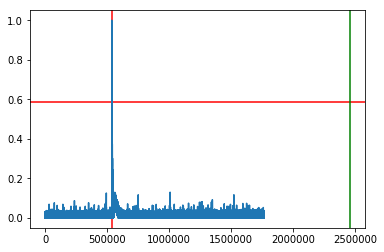

0:00:04.406096
5 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/15/04/20170915045815611_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/15/04/20170915045815611_SVAKOV-R12_raws.fits
delka zaznamu          : 64.00002048 s
cas prvni vzorku s GPS : 0.30008342936 s
cas 1. GPS a konec     : 63.69993705064 s
SysCas ukladani souboru: 2017-09-15 04:58:15 s
SysCas zacatku souboru : 2017-09-15 04:57:10.999980
SysCas 1. GPS znacky   : 2017-09-15 04:57:11.300063
Korekce systémoveho čas: -1 day, 23:59:58.699937
CorCas ukladani souboru: 2017-09-15 04:58:13.699937 s
CorCas zacatku souboru : 2017-09-15 04:57:09.699917
CorCas 1. GPS znacky   : 2017-09-15 04:57:10


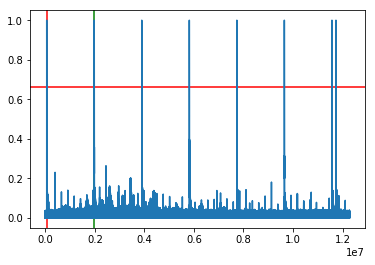

-1 day, 23:59:58.699937
6 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/15/04/20170915043312379_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/15/04/20170915043312379_SVAKOV-R12_raws.fits
delka zaznamu          : 13.800004416 s
cas prvni vzorku s GPS : 4.3230326333699995 s
cas 1. GPS a konec     : 9.47697178263 s
SysCas ukladani souboru: 2017-09-15 04:33:12 s
SysCas zacatku souboru : 2017-09-15 04:32:58.199996
SysCas 1. GPS znacky   : 2017-09-15 04:33:02.523028
Korekce systémoveho čas: -1 day, 23:59:57.476972
CorCas ukladani souboru: 2017-09-15 04:33:09.476972 s
CorCas zacatku souboru : 2017-09-15 04:32:55.676968
CorCas 1. GPS znacky   : 2017-09-15 04:33:00


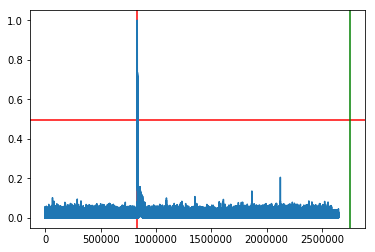

-1 day, 23:59:57.476972
7 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/15/00/20170915001758117_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/15/00/20170915001758117_SVAKOV-R12_raws.fits
delka zaznamu          : 13.000004159999998 s
cas prvni vzorku s GPS : 6.857174069295 s
cas 1. GPS a konec     : 6.142830090704998 s
SysCas ukladani souboru: 2017-09-15 00:17:58 s
SysCas zacatku souboru : 2017-09-15 00:17:44.999996
SysCas 1. GPS znacky   : 2017-09-15 00:17:51.857170
Korekce systémoveho čas: -1 day, 23:59:58.142830
CorCas ukladani souboru: 2017-09-15 00:17:56.142830 s
CorCas zacatku souboru : 2017-09-15 00:17:43.142826
CorCas 1. GPS znacky   : 2017-09-15 00:17:50


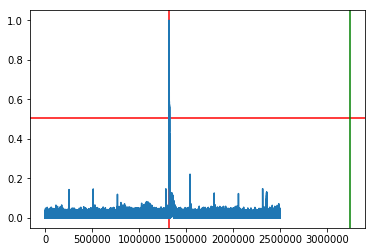

-1 day, 23:59:58.142830
8 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/14/21/20170914213054352_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/14/21/20170914213054352_SVAKOV-R12_raws.fits
delka zaznamu          : 9.19999252733 s
cas prvni vzorku s GPS : 6.023647760899999 s
cas 1. GPS a konec     : 3.1763447664300006 s
SysCas ukladani souboru: 2017-09-14 21:30:54 s
SysCas zacatku souboru : 2017-09-14 21:30:44.800007
SysCas 1. GPS znacky   : 2017-09-14 21:30:50.823655
Korekce systémoveho čas: -1 day, 23:59:59.176345
CorCas ukladani souboru: 2017-09-14 21:30:53.176345 s
CorCas zacatku souboru : 2017-09-14 21:30:43.976352
CorCas 1. GPS znacky   : 2017-09-14 21:30:50


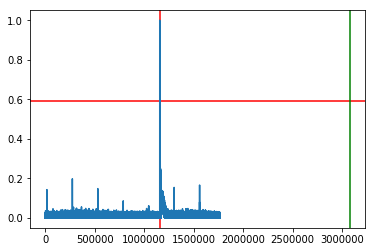

-1 day, 23:59:59.176345
9 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/14/14/20170914140653456_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/14/14/20170914140653456_SVAKOV-R12_raws.fits
delka zaznamu          : 10.800003455999999 s
cas prvni vzorku s GPS : 2.5402403962099998 s
cas 1. GPS a konec     : 8.25976305979 s
SysCas ukladani souboru: 2017-09-14 14:06:53 s
SysCas zacatku souboru : 2017-09-14 14:06:42.199997
SysCas 1. GPS znacky   : 2017-09-14 14:06:44.740237
Korekce systémoveho čas: -1 day, 23:59:55.259763
CorCas ukladani souboru: 2017-09-14 14:06:48.259763 s
CorCas zacatku souboru : 2017-09-14 14:06:37.459760
CorCas 1. GPS znacky   : 2017-09-14 14:06:40


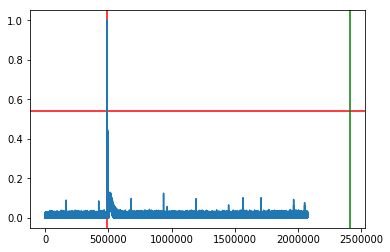

-1 day, 23:59:55.259763
10 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/14/11/20170914115657744_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/14/11/20170914115657744_SVAKOV-R12_raws.fits
delka zaznamu          : 11.00000352 s
cas prvni vzorku s GPS : 2.51865705597 s
cas 1. GPS a konec     : 8.48134646403 s
SysCas ukladani souboru: 2017-09-14 11:56:57 s
SysCas zacatku souboru : 2017-09-14 11:56:45.999996
SysCas 1. GPS znacky   : 2017-09-14 11:56:48.518654
Korekce systémoveho čas: 0:00:01.481346
CorCas ukladani souboru: 2017-09-14 11:56:58.481346 s
CorCas zacatku souboru : 2017-09-14 11:56:47.481342
CorCas 1. GPS znacky   : 2017-09-14 11:56:50


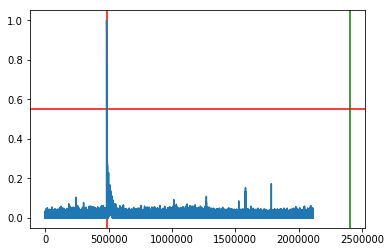

0:00:01.481346
11 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/14/09/20170914095950544_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/14/09/20170914095950544_SVAKOV-R12_raws.fits
delka zaznamu          : 10.400003327999999 s
cas prvni vzorku s GPS : 3.6247928266 s
cas 1. GPS a konec     : 6.775210501399998 s
SysCas ukladani souboru: 2017-09-14 09:59:50 s
SysCas zacatku souboru : 2017-09-14 09:59:39.599997
SysCas 1. GPS znacky   : 2017-09-14 09:59:43.224789
Korekce systémoveho čas: -1 day, 23:59:56.775211
CorCas ukladani souboru: 2017-09-14 09:59:46.775211 s
CorCas zacatku souboru : 2017-09-14 09:59:36.375208
CorCas 1. GPS znacky   : 2017-09-14 09:59:40


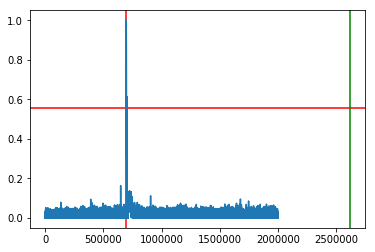

-1 day, 23:59:56.775211
12 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/14/05/20170914054205413_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/14/05/20170914054205413_SVAKOV-R12_raws.fits
delka zaznamu          : 18.800006016 s
cas prvni vzorku s GPS : 7.22202314438 s
cas 1. GPS a konec     : 11.577982871620002 s
SysCas ukladani souboru: 2017-09-14 05:42:05 s
SysCas zacatku souboru : 2017-09-14 05:41:46.199994
SysCas 1. GPS znacky   : 2017-09-14 05:41:53.422017
Korekce systémoveho čas: -1 day, 23:59:56.577983
CorCas ukladani souboru: 2017-09-14 05:42:01.577983 s
CorCas zacatku souboru : 2017-09-14 05:41:42.777977
CorCas 1. GPS znacky   : 2017-09-14 05:41:50


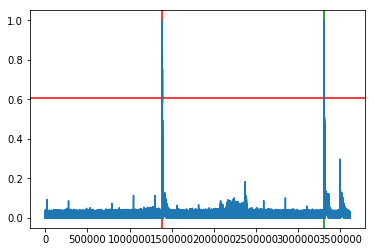

-1 day, 23:59:56.577983
13 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/14/04/20170914040841573_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/14/04/20170914040841573_SVAKOV-R12_raws.fits
delka zaznamu          : 9.400003008 s
cas prvni vzorku s GPS : 4.58735563462 s
cas 1. GPS a konec     : 4.812647373380001 s
SysCas ukladani souboru: 2017-09-14 04:08:41 s
SysCas zacatku souboru : 2017-09-14 04:08:31.599997
SysCas 1. GPS znacky   : 2017-09-14 04:08:36.187353
Korekce systémoveho čas: 0:00:03.812647
CorCas ukladani souboru: 2017-09-14 04:08:44.812647 s
CorCas zacatku souboru : 2017-09-14 04:08:35.412644
CorCas 1. GPS znacky   : 2017-09-14 04:08:40


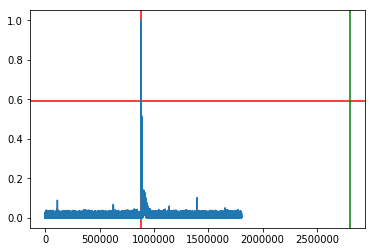

0:00:03.812647
14 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/14/03/20170914032734075_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/14/03/20170914032734075_SVAKOV-R12_raws.fits
delka zaznamu          : 11.200003584 s
cas prvni vzorku s GPS : 3.42475109592 s
cas 1. GPS a konec     : 7.77525248808 s
SysCas ukladani souboru: 2017-09-14 03:27:34 s
SysCas zacatku souboru : 2017-09-14 03:27:22.799996
SysCas 1. GPS znacky   : 2017-09-14 03:27:26.224748
Korekce systémoveho čas: 0:00:03.775252
CorCas ukladani souboru: 2017-09-14 03:27:37.775252 s
CorCas zacatku souboru : 2017-09-14 03:27:26.575248
CorCas 1. GPS znacky   : 2017-09-14 03:27:30


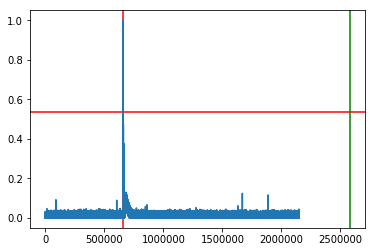

0:00:03.775252
15 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/14/01/20170914012957349_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/14/01/20170914012957349_SVAKOV-R12_raws.fits
delka zaznamu          : 9.800003135999999 s
cas prvni vzorku s GPS : 4.00912628292 s
cas 1. GPS a konec     : 5.790876853079999 s
SysCas ukladani souboru: 2017-09-14 01:29:57 s
SysCas zacatku souboru : 2017-09-14 01:29:47.199997
SysCas 1. GPS znacky   : 2017-09-14 01:29:51.209123
Korekce systémoveho čas: -1 day, 23:59:58.790877
CorCas ukladani souboru: 2017-09-14 01:29:55.790877 s
CorCas zacatku souboru : 2017-09-14 01:29:45.990874
CorCas 1. GPS znacky   : 2017-09-14 01:29:50


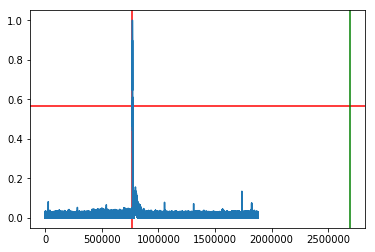

-1 day, 23:59:58.790877
16 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/14/01/20170914012045243_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/14/01/20170914012045243_SVAKOV-R12_raws.fits
delka zaznamu          : 11.00000352 s
cas prvni vzorku s GPS : 6.519637502949999 s
cas 1. GPS a konec     : 4.480366017050001 s
SysCas ukladani souboru: 2017-09-14 01:20:45 s
SysCas zacatku souboru : 2017-09-14 01:20:33.999996
SysCas 1. GPS znacky   : 2017-09-14 01:20:40.519634
Korekce systémoveho čas: -1 day, 23:59:59.480366
CorCas ukladani souboru: 2017-09-14 01:20:44.480366 s
CorCas zacatku souboru : 2017-09-14 01:20:33.480362
CorCas 1. GPS znacky   : 2017-09-14 01:20:40


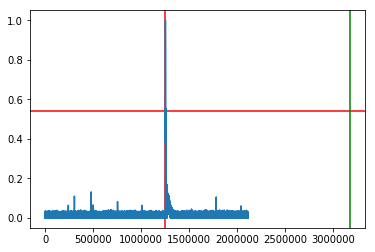

-1 day, 23:59:59.480366
17 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/14/01/20170914010548731_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/14/01/20170914010548731_SVAKOV-R12_raws.fits
delka zaznamu          : 9.400003008 s
cas prvni vzorku s GPS : 3.5784073950899997 s
cas 1. GPS a konec     : 5.82159561291 s
SysCas ukladani souboru: 2017-09-14 01:05:48 s
SysCas zacatku souboru : 2017-09-14 01:05:38.599997
SysCas 1. GPS znacky   : 2017-09-14 01:05:42.178404
Korekce systémoveho čas: -1 day, 23:59:57.821596
CorCas ukladani souboru: 2017-09-14 01:05:45.821596 s
CorCas zacatku souboru : 2017-09-14 01:05:36.421593
CorCas 1. GPS znacky   : 2017-09-14 01:05:40


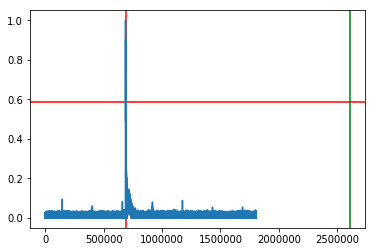

-1 day, 23:59:57.821596
18 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/14/00/20170914002021989_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/14/00/20170914002021989_SVAKOV-R12_raws.fits
delka zaznamu          : 23.800007616 s
cas prvni vzorku s GPS : 1.98525063528 s
cas 1. GPS a konec     : 21.81475698072 s
SysCas ukladani souboru: 2017-09-14 00:20:21 s
SysCas zacatku souboru : 2017-09-14 00:19:57.199992
SysCas 1. GPS znacky   : 2017-09-14 00:19:59.185243
Korekce systémoveho čas: 0:00:00.814757
CorCas ukladani souboru: 2017-09-14 00:20:21.814757 s
CorCas zacatku souboru : 2017-09-14 00:19:58.014749
CorCas 1. GPS znacky   : 2017-09-14 00:20:00


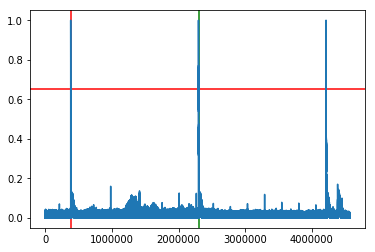

0:00:00.814757
19 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/13/21/20170913213756240_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/13/21/20170913213756240_SVAKOV-R12_raws.fits
delka zaznamu          : 9.19999252733 s
cas prvni vzorku s GPS : 2.9219592683599998 s
cas 1. GPS a konec     : 6.27803325897 s
SysCas ukladani souboru: 2017-09-13 21:37:56 s
SysCas zacatku souboru : 2017-09-13 21:37:46.800007
SysCas 1. GPS znacky   : 2017-09-13 21:37:49.721967
Korekce systémoveho čas: 0:00:00.278033
CorCas ukladani souboru: 2017-09-13 21:37:56.278033 s
CorCas zacatku souboru : 2017-09-13 21:37:47.078040
CorCas 1. GPS znacky   : 2017-09-13 21:37:50


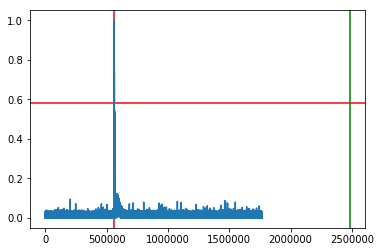

0:00:00.278033
20 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/13/15/20170913152000272_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/13/15/20170913152000272_SVAKOV-R12_raws.fits
delka zaznamu          : 9.600003072 s
cas prvni vzorku s GPS : 1.8774381007799998 s
cas 1. GPS a konec     : 7.72256497122 s
SysCas ukladani souboru: 2017-09-13 15:20:00 s
SysCas zacatku souboru : 2017-09-13 15:19:50.399997
SysCas 1. GPS znacky   : 2017-09-13 15:19:52.277435
Korekce systémoveho čas: -1 day, 23:59:57.722565
CorCas ukladani souboru: 2017-09-13 15:19:57.722565 s
CorCas zacatku souboru : 2017-09-13 15:19:48.122562
CorCas 1. GPS znacky   : 2017-09-13 15:19:50


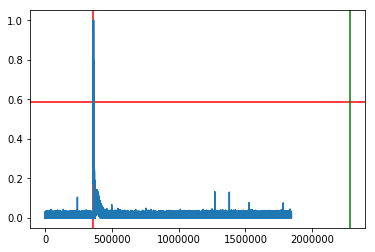

-1 day, 23:59:57.722565
21 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/13/07/20170913070029840_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/13/07/20170913070029840_SVAKOV-R12_raws.fits
delka zaznamu          : 9.600003072 s
cas prvni vzorku s GPS : 9.599997863665 s
cas 1. GPS a konec     : 5.208335000617126e-06 s
SysCas ukladani souboru: 2017-09-13 07:00:29 s
SysCas zacatku souboru : 2017-09-13 07:00:19.399997
SysCas 1. GPS znacky   : 2017-09-13 07:00:28.999995
Korekce systémoveho čas: 0:00:01.000005
CorCas ukladani souboru: 2017-09-13 07:00:30.000005 s
CorCas zacatku souboru : 2017-09-13 07:00:20.400002
CorCas 1. GPS znacky   : 2017-09-13 07:00:30


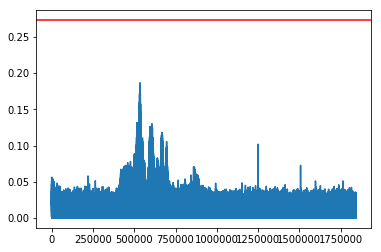

0:00:01.000005
22 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/13/06/20170913062413499_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/13/06/20170913062413499_SVAKOV-R12_raws.fits
delka zaznamu          : 24.200007743999997 s
cas prvni vzorku s GPS : 7.205085638959999 s
cas 1. GPS a konec     : 16.994922105039997 s
SysCas ukladani souboru: 2017-09-13 06:24:13 s
SysCas zacatku souboru : 2017-09-13 06:23:48.799992
SysCas 1. GPS znacky   : 2017-09-13 06:23:56.005078
Korekce systémoveho čas: 0:00:03.994922
CorCas ukladani souboru: 2017-09-13 06:24:16.994922 s
CorCas zacatku souboru : 2017-09-13 06:23:52.794914
CorCas 1. GPS znacky   : 2017-09-13 06:24:00


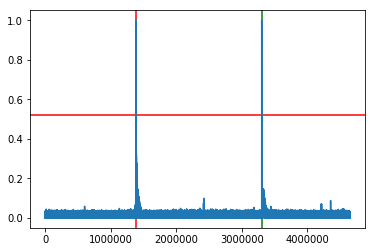

0:00:03.994922
23 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/13/05/20170913052213136_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/13/05/20170913052213136_SVAKOV-R12_raws.fits
delka zaznamu          : 22.400007168 s
cas prvni vzorku s GPS : 9.65387808924 s
cas 1. GPS a konec     : 12.74612907876 s
SysCas ukladani souboru: 2017-09-13 05:22:13 s
SysCas zacatku souboru : 2017-09-13 05:21:50.599993
SysCas 1. GPS znacky   : 2017-09-13 05:22:00.253871
Korekce systémoveho čas: -1 day, 23:59:59.746129
CorCas ukladani souboru: 2017-09-13 05:22:12.746129 s
CorCas zacatku souboru : 2017-09-13 05:21:50.346122
CorCas 1. GPS znacky   : 2017-09-13 05:22:00


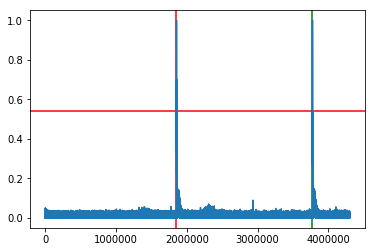

-1 day, 23:59:59.746129
24 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/13/04/20170913042415803_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/13/04/20170913042415803_SVAKOV-R12_raws.fits
delka zaznamu          : 11.400003648 s
cas prvni vzorku s GPS : 8.95584661587 s
cas 1. GPS a konec     : 2.4441570321300006 s
SysCas ukladani souboru: 2017-09-13 04:24:15 s
SysCas zacatku souboru : 2017-09-13 04:24:03.599996
SysCas 1. GPS znacky   : 2017-09-13 04:24:12.555843
Korekce systémoveho čas: -1 day, 23:59:57.444157
CorCas ukladani souboru: 2017-09-13 04:24:12.444157 s
CorCas zacatku souboru : 2017-09-13 04:24:01.044153
CorCas 1. GPS znacky   : 2017-09-13 04:24:10


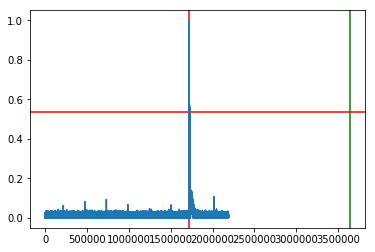

-1 day, 23:59:57.444157
25 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/13/00/20170913000212965_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/13/00/20170913000212965_SVAKOV-R12_raws.fits
delka zaznamu          : 10.199992847329998 s
cas prvni vzorku s GPS : 0.17055213791 s
cas 1. GPS a konec     : 10.029440709419998 s
SysCas ukladani souboru: 2017-09-13 00:02:12 s
SysCas zacatku souboru : 2017-09-13 00:02:01.800007
SysCas 1. GPS znacky   : 2017-09-13 00:02:01.970559
Korekce systémoveho čas: -1 day, 23:59:58.029441
CorCas ukladani souboru: 2017-09-13 00:02:10.029441 s
CorCas zacatku souboru : 2017-09-13 00:01:59.829448
CorCas 1. GPS znacky   : 2017-09-13 00:02:00


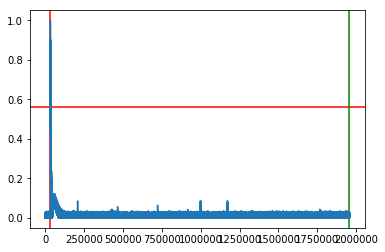

-1 day, 23:59:58.029441
26 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/14/20170912140211003_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/14/20170912140211003_SVAKOV-R12_raws.fits
delka zaznamu          : 9.600003072 s
cas prvni vzorku s GPS : 5.8415956193100005 s
cas 1. GPS a konec     : 3.7584074526899993 s
SysCas ukladani souboru: 2017-09-12 14:02:11 s
SysCas zacatku souboru : 2017-09-12 14:02:01.399997
SysCas 1. GPS znacky   : 2017-09-12 14:02:07.241593
Korekce systémoveho čas: 0:00:02.758407
CorCas ukladani souboru: 2017-09-12 14:02:13.758407 s
CorCas zacatku souboru : 2017-09-12 14:02:04.158404
CorCas 1. GPS znacky   : 2017-09-12 14:02:10


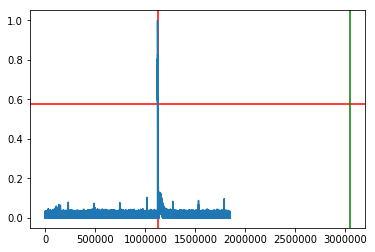

0:00:02.758407
27 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/13/20170912134534480_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/13/20170912134534480_SVAKOV-R12_raws.fits
delka zaznamu          : 18.399995471329998 s
cas prvni vzorku s GPS : 2.3914382652599997 s
cas 1. GPS a konec     : 16.008557206069998 s
SysCas ukladani souboru: 2017-09-12 13:45:34 s
SysCas zacatku souboru : 2017-09-12 13:45:15.600005
SysCas 1. GPS znacky   : 2017-09-12 13:45:17.991443
Korekce systémoveho čas: 0:00:02.008557
CorCas ukladani souboru: 2017-09-12 13:45:36.008557 s
CorCas zacatku souboru : 2017-09-12 13:45:17.608562
CorCas 1. GPS znacky   : 2017-09-12 13:45:20


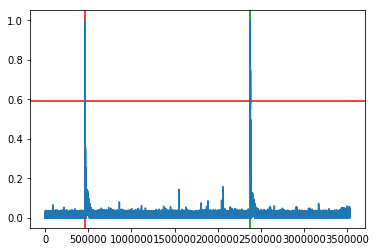

0:00:02.008557
28 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/12/20170912123021712_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/12/20170912123021712_SVAKOV-R12_raws.fits
delka zaznamu          : 14.600004671999999 s
cas prvni vzorku s GPS : 4.9092724043 s
cas 1. GPS a konec     : 9.6907322677 s
SysCas ukladani souboru: 2017-09-12 12:30:21 s
SysCas zacatku souboru : 2017-09-12 12:30:06.399995
SysCas 1. GPS znacky   : 2017-09-12 12:30:11.309268
Korekce systémoveho čas: -1 day, 23:59:58.690732
CorCas ukladani souboru: 2017-09-12 12:30:19.690732 s
CorCas zacatku souboru : 2017-09-12 12:30:05.090727
CorCas 1. GPS znacky   : 2017-09-12 12:30:10


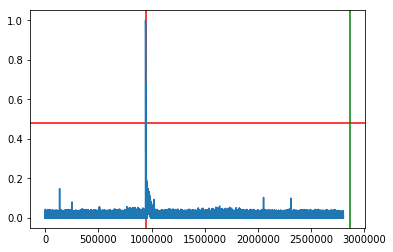

-1 day, 23:59:58.690732
29 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/11/20170912111735888_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/11/20170912111735888_SVAKOV-R12_raws.fits
delka zaznamu          : 10.000003199999998 s
cas prvni vzorku s GPS : 0.6974689731899999 s
cas 1. GPS a konec     : 9.302534226809998 s
SysCas ukladani souboru: 2017-09-12 11:17:35 s
SysCas zacatku souboru : 2017-09-12 11:17:24.999997
SysCas 1. GPS znacky   : 2017-09-12 11:17:25.697466
Korekce systémoveho čas: 0:00:04.302534
CorCas ukladani souboru: 2017-09-12 11:17:39.302534 s
CorCas zacatku souboru : 2017-09-12 11:17:29.302531
CorCas 1. GPS znacky   : 2017-09-12 11:17:30


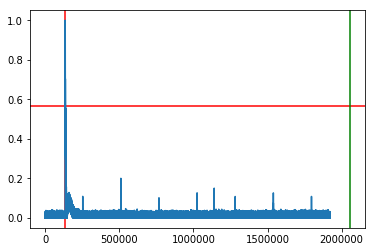

0:00:04.302534
30 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/09/20170912090908240_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/09/20170912090908240_SVAKOV-R12_raws.fits
delka zaznamu          : 9.800003135999999 s
cas prvni vzorku s GPS : 8.24451305491 s
cas 1. GPS a konec     : 1.5554900810899994 s
SysCas ukladani souboru: 2017-09-12 09:09:08 s
SysCas zacatku souboru : 2017-09-12 09:08:58.199997
SysCas 1. GPS znacky   : 2017-09-12 09:09:06.444510
Korekce systémoveho čas: 0:00:03.555490
CorCas ukladani souboru: 2017-09-12 09:09:11.555490 s
CorCas zacatku souboru : 2017-09-12 09:09:01.755487
CorCas 1. GPS znacky   : 2017-09-12 09:09:10


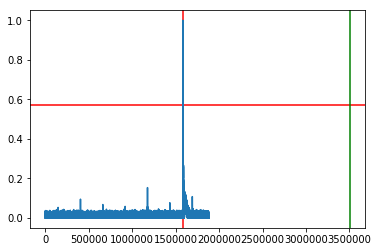

0:00:03.555490
31 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/07/20170912073638160_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/07/20170912073638160_SVAKOV-R12_raws.fits
delka zaznamu          : 11.200003584 s
cas prvni vzorku s GPS : 8.11006509522 s
cas 1. GPS a konec     : 3.0899384887799997 s
SysCas ukladani souboru: 2017-09-12 07:36:38 s
SysCas zacatku souboru : 2017-09-12 07:36:26.799996
SysCas 1. GPS znacky   : 2017-09-12 07:36:34.910062
Korekce systémoveho čas: -1 day, 23:59:55.089938
CorCas ukladani souboru: 2017-09-12 07:36:33.089938 s
CorCas zacatku souboru : 2017-09-12 07:36:21.889934
CorCas 1. GPS znacky   : 2017-09-12 07:36:30


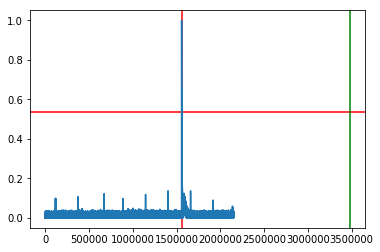

-1 day, 23:59:55.089938
32 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/07/20170912072340944_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/07/20170912072340944_SVAKOV-R12_raws.fits
delka zaznamu          : 11.600003712 s
cas prvni vzorku s GPS : 5.284939191179999 s
cas 1. GPS a konec     : 6.31506452082 s
SysCas ukladani souboru: 2017-09-12 07:23:40 s
SysCas zacatku souboru : 2017-09-12 07:23:28.399996
SysCas 1. GPS znacky   : 2017-09-12 07:23:33.684935
Korekce systémoveho čas: -1 day, 23:59:56.315065
CorCas ukladani souboru: 2017-09-12 07:23:36.315065 s
CorCas zacatku souboru : 2017-09-12 07:23:24.715061
CorCas 1. GPS znacky   : 2017-09-12 07:23:30


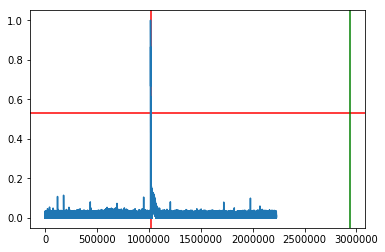

-1 day, 23:59:56.315065
33 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/07/20170912071645712_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/07/20170912071645712_SVAKOV-R12_raws.fits
delka zaznamu          : 11.400003648 s
cas prvni vzorku s GPS : 0.5328022538299999 s
cas 1. GPS a konec     : 10.86720139417 s
SysCas ukladani souboru: 2017-09-12 07:16:45 s
SysCas zacatku souboru : 2017-09-12 07:16:33.599996
SysCas 1. GPS znacky   : 2017-09-12 07:16:34.132799
Korekce systémoveho čas: -1 day, 23:59:55.867201
CorCas ukladani souboru: 2017-09-12 07:16:40.867201 s
CorCas zacatku souboru : 2017-09-12 07:16:29.467197
CorCas 1. GPS znacky   : 2017-09-12 07:16:30


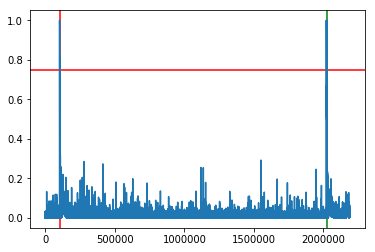

-1 day, 23:59:55.867201
34 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/07/20170912071637691_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/07/20170912071637691_SVAKOV-R12_raws.fits
delka zaznamu          : 10.600003391999998 s
cas prvni vzorku s GPS : 8.55413815399 s
cas 1. GPS a konec     : 2.0458652380099984 s
SysCas ukladani souboru: 2017-09-12 07:16:37 s
SysCas zacatku souboru : 2017-09-12 07:16:26.399997
SysCas 1. GPS znacky   : 2017-09-12 07:16:34.954135
Korekce systémoveho čas: -1 day, 23:59:55.045865
CorCas ukladani souboru: 2017-09-12 07:16:32.045865 s
CorCas zacatku souboru : 2017-09-12 07:16:21.445862
CorCas 1. GPS znacky   : 2017-09-12 07:16:30


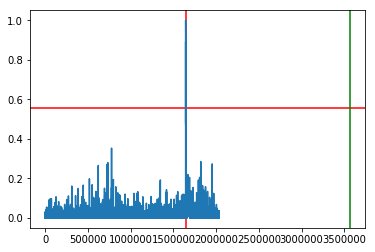

-1 day, 23:59:55.045865
35 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/06/20170912065431099_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/06/20170912065431099_SVAKOV-R12_raws.fits
delka zaznamu          : 10.600003391999998 s
cas prvni vzorku s GPS : 5.11612663716 s
cas 1. GPS a konec     : 5.483876754839998 s
SysCas ukladani souboru: 2017-09-12 06:54:31 s
SysCas zacatku souboru : 2017-09-12 06:54:20.399997
SysCas 1. GPS znacky   : 2017-09-12 06:54:25.516123
Korekce systémoveho čas: 0:00:04.483877
CorCas ukladani souboru: 2017-09-12 06:54:35.483877 s
CorCas zacatku souboru : 2017-09-12 06:54:24.883874
CorCas 1. GPS znacky   : 2017-09-12 06:54:30


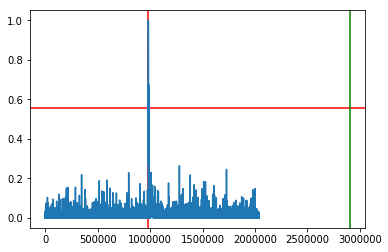

0:00:04.483877
36 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/06/20170912063806523_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/06/20170912063806523_SVAKOV-R12_raws.fits
delka zaznamu          : 9.19999252733 s
cas prvni vzorku s GPS : 1.3411618875049998 s
cas 1. GPS a konec     : 7.858830639825 s
SysCas ukladani souboru: 2017-09-12 06:38:06 s
SysCas zacatku souboru : 2017-09-12 06:37:56.800007
SysCas 1. GPS znacky   : 2017-09-12 06:37:58.141169
Korekce systémoveho čas: 0:00:01.858831
CorCas ukladani souboru: 2017-09-12 06:38:07.858831 s
CorCas zacatku souboru : 2017-09-12 06:37:58.658838
CorCas 1. GPS znacky   : 2017-09-12 06:38:00


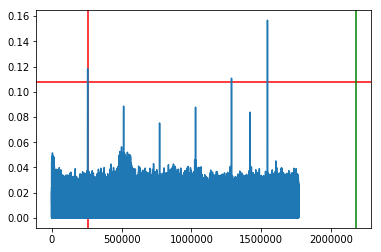

0:00:01.858831
37 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/06/20170912062559824_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/06/20170912062559824_SVAKOV-R12_raws.fits
delka zaznamu          : 15.600004991999999 s
cas prvni vzorku s GPS : 6.303710350519999 s
cas 1. GPS a konec     : 9.29629464148 s
SysCas ukladani souboru: 2017-09-12 06:25:59 s
SysCas zacatku souboru : 2017-09-12 06:25:43.399995
SysCas 1. GPS znacky   : 2017-09-12 06:25:49.703705
Korekce systémoveho čas: 0:00:00.296295
CorCas ukladani souboru: 2017-09-12 06:25:59.296295 s
CorCas zacatku souboru : 2017-09-12 06:25:43.696290
CorCas 1. GPS znacky   : 2017-09-12 06:25:50


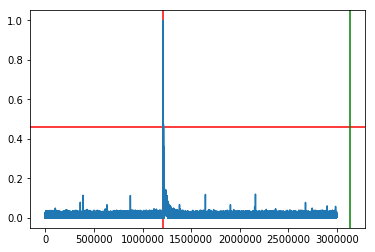

0:00:00.296295
38 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/06/20170912061213797_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/06/20170912061213797_SVAKOV-R12_raws.fits
delka zaznamu          : 14.200004543999999 s
cas prvni vzorku s GPS : 2.31434449059 s
cas 1. GPS a konec     : 11.88566005341 s
SysCas ukladani souboru: 2017-09-12 06:12:13 s
SysCas zacatku souboru : 2017-09-12 06:11:58.799995
SysCas 1. GPS znacky   : 2017-09-12 06:12:01.114340
Korekce systémoveho čas: -1 day, 23:59:58.885660
CorCas ukladani souboru: 2017-09-12 06:12:11.885660 s
CorCas zacatku souboru : 2017-09-12 06:11:57.685655
CorCas 1. GPS znacky   : 2017-09-12 06:12:00


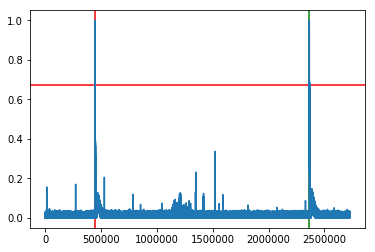

-1 day, 23:59:58.885660
39 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/06/20170912060951803_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/06/20170912060951803_SVAKOV-R12_raws.fits
delka zaznamu          : 17.000005440000002 s
cas prvni vzorku s GPS : 4.31181387978 s
cas 1. GPS a konec     : 12.688191560220002 s
SysCas ukladani souboru: 2017-09-12 06:09:51 s
SysCas zacatku souboru : 2017-09-12 06:09:33.999995
SysCas 1. GPS znacky   : 2017-09-12 06:09:38.311808
Korekce systémoveho čas: 0:00:01.688192
CorCas ukladani souboru: 2017-09-12 06:09:52.688192 s
CorCas zacatku souboru : 2017-09-12 06:09:35.688187
CorCas 1. GPS znacky   : 2017-09-12 06:09:40


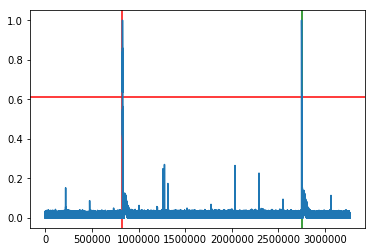

0:00:01.688192
40 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/06/20170912060317051_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/06/20170912060317051_SVAKOV-R12_raws.fits
delka zaznamu          : 13.200004223999999 s
cas prvni vzorku s GPS : 2.6055737504499996 s
cas 1. GPS a konec     : 10.594430473549998 s
SysCas ukladani souboru: 2017-09-12 06:03:17 s
SysCas zacatku souboru : 2017-09-12 06:03:03.799996
SysCas 1. GPS znacky   : 2017-09-12 06:03:06.405570
Korekce systémoveho čas: 0:00:03.594430
CorCas ukladani souboru: 2017-09-12 06:03:20.594430 s
CorCas zacatku souboru : 2017-09-12 06:03:07.394426
CorCas 1. GPS znacky   : 2017-09-12 06:03:10


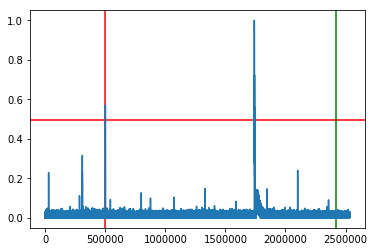

0:00:03.594430
41 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/05/20170912054532261_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/05/20170912054532261_SVAKOV-R12_raws.fits
delka zaznamu          : 20.200006463999998 s
cas prvni vzorku s GPS : 3.8008553829399996 s
cas 1. GPS a konec     : 16.399151081059998 s
SysCas ukladani souboru: 2017-09-12 05:45:32 s
SysCas zacatku souboru : 2017-09-12 05:45:11.799994
SysCas 1. GPS znacky   : 2017-09-12 05:45:15.600849
Korekce systémoveho čas: 0:00:04.399151
CorCas ukladani souboru: 2017-09-12 05:45:36.399151 s
CorCas zacatku souboru : 2017-09-12 05:45:16.199145
CorCas 1. GPS znacky   : 2017-09-12 05:45:20


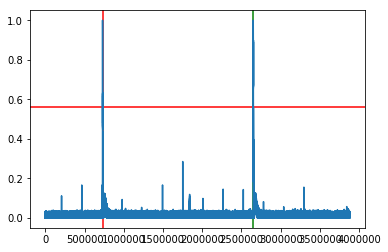

0:00:04.399151
42 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/04/20170912044927739_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/04/20170912044927739_SVAKOV-R12_raws.fits
delka zaznamu          : 10.600003391999998 s
cas prvni vzorku s GPS : 8.21227346126 s
cas 1. GPS a konec     : 2.3877299307399973 s
SysCas ukladani souboru: 2017-09-12 04:49:27 s
SysCas zacatku souboru : 2017-09-12 04:49:16.399997
SysCas 1. GPS znacky   : 2017-09-12 04:49:24.612270
Korekce systémoveho čas: -1 day, 23:59:55.387730
CorCas ukladani souboru: 2017-09-12 04:49:22.387730 s
CorCas zacatku souboru : 2017-09-12 04:49:11.787727
CorCas 1. GPS znacky   : 2017-09-12 04:49:20


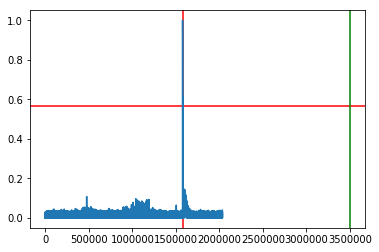

-1 day, 23:59:55.387730
43 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/02/20170912023928443_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/02/20170912023928443_SVAKOV-R12_raws.fits
delka zaznamu          : 10.199992847329998 s
cas prvni vzorku s GPS : 7.22480439527 s
cas 1. GPS a konec     : 2.9751884520599985 s
SysCas ukladani souboru: 2017-09-12 02:39:28 s
SysCas zacatku souboru : 2017-09-12 02:39:17.800007
SysCas 1. GPS znacky   : 2017-09-12 02:39:25.024812
Korekce systémoveho čas: 0:00:04.975188
CorCas ukladani souboru: 2017-09-12 02:39:32.975188 s
CorCas zacatku souboru : 2017-09-12 02:39:22.775195
CorCas 1. GPS znacky   : 2017-09-12 02:39:30


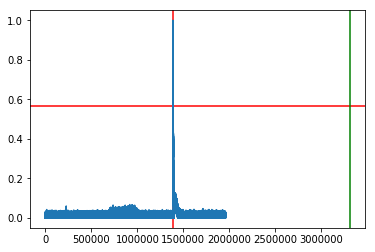

0:00:04.975188
44 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/00/20170912005545595_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/12/00/20170912005545595_SVAKOV-R12_raws.fits
delka zaznamu          : 21.800006975999995 s
cas prvni vzorku s GPS : 0.03914584585999999 s
cas 1. GPS a konec     : 21.760861130139997 s
SysCas ukladani souboru: 2017-09-12 00:55:45 s
SysCas zacatku souboru : 2017-09-12 00:55:23.199993
SysCas 1. GPS znacky   : 2017-09-12 00:55:23.239139
Korekce systémoveho čas: -1 day, 23:59:56.760861
CorCas ukladani souboru: 2017-09-12 00:55:41.760861 s
CorCas zacatku souboru : 2017-09-12 00:55:19.960854
CorCas 1. GPS znacky   : 2017-09-12 00:55:20


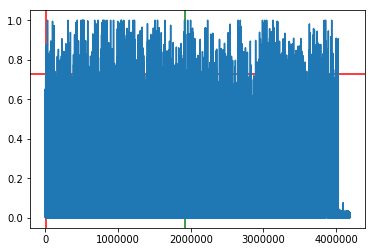

-1 day, 23:59:56.760861
45 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/11/22/20170911222911995_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/11/22/20170911222911995_SVAKOV-R12_raws.fits
delka zaznamu          : 9.19999252733 s
cas prvni vzorku s GPS : 3.3752927467599996 s
cas 1. GPS a konec     : 5.8246997805700005 s
SysCas ukladani souboru: 2017-09-11 22:29:11 s
SysCas zacatku souboru : 2017-09-11 22:29:01.800007
SysCas 1. GPS znacky   : 2017-09-11 22:29:05.175300
Korekce systémoveho čas: 0:00:04.824700
CorCas ukladani souboru: 2017-09-11 22:29:15.824700 s
CorCas zacatku souboru : 2017-09-11 22:29:06.624707
CorCas 1. GPS znacky   : 2017-09-11 22:29:10


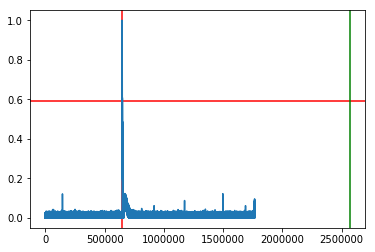

0:00:04.824700
46 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/11/14/20170911140913744_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/11/14/20170911140913744_SVAKOV-R12_raws.fits
delka zaznamu          : 10.000003199999998 s
cas prvni vzorku s GPS : 0.48933348992 s
cas 1. GPS a konec     : 9.510669710079998 s
SysCas ukladani souboru: 2017-09-11 14:09:13 s
SysCas zacatku souboru : 2017-09-11 14:09:02.999997
SysCas 1. GPS znacky   : 2017-09-11 14:09:03.489330
Korekce systémoveho čas: -1 day, 23:59:56.510670
CorCas ukladani souboru: 2017-09-11 14:09:09.510670 s
CorCas zacatku souboru : 2017-09-11 14:08:59.510667
CorCas 1. GPS znacky   : 2017-09-11 14:09:00


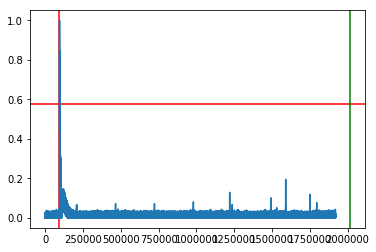

-1 day, 23:59:56.510670
47 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/11/12/20170911120307237_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/11/12/20170911120307237_SVAKOV-R12_raws.fits
delka zaznamu          : 11.400003648 s
cas prvni vzorku s GPS : 6.88518970326 s
cas 1. GPS a konec     : 4.51481394474 s
SysCas ukladani souboru: 2017-09-11 12:03:07 s
SysCas zacatku souboru : 2017-09-11 12:02:55.599996
SysCas 1. GPS znacky   : 2017-09-11 12:03:02.485186
Korekce systémoveho čas: -1 day, 23:59:57.514814
CorCas ukladani souboru: 2017-09-11 12:03:04.514814 s
CorCas zacatku souboru : 2017-09-11 12:02:53.114810
CorCas 1. GPS znacky   : 2017-09-11 12:03:00


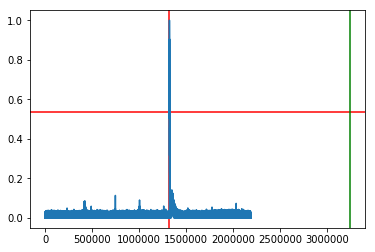

-1 day, 23:59:57.514814
48 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/11/11/20170911111629328_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/11/11/20170911111629328_SVAKOV-R12_raws.fits
delka zaznamu          : 10.600003391999998 s
cas prvni vzorku s GPS : 4.697189003099999 s
cas 1. GPS a konec     : 5.902814388899999 s
SysCas ukladani souboru: 2017-09-11 11:16:29 s
SysCas zacatku souboru : 2017-09-11 11:16:18.399997
SysCas 1. GPS znacky   : 2017-09-11 11:16:23.097186
Korekce systémoveho čas: -1 day, 23:59:56.902814
CorCas ukladani souboru: 2017-09-11 11:16:25.902814 s
CorCas zacatku souboru : 2017-09-11 11:16:15.302811
CorCas 1. GPS znacky   : 2017-09-11 11:16:20


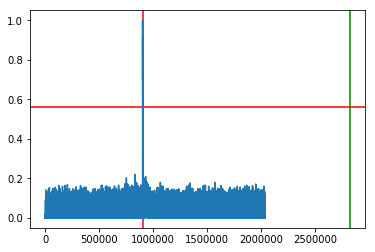

-1 day, 23:59:56.902814
49 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/11/11/20170911111456997_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/11/11/20170911111456997_SVAKOV-R12_raws.fits
delka zaznamu          : 9.400003008 s
cas prvni vzorku s GPS : 7.02139808018 s
cas 1. GPS a konec     : 2.3786049278200005 s
SysCas ukladani souboru: 2017-09-11 11:14:56 s
SysCas zacatku souboru : 2017-09-11 11:14:46.599997
SysCas 1. GPS znacky   : 2017-09-11 11:14:53.621395
Korekce systémoveho čas: -1 day, 23:59:56.378605
CorCas ukladani souboru: 2017-09-11 11:14:52.378605 s
CorCas zacatku souboru : 2017-09-11 11:14:42.978602
CorCas 1. GPS znacky   : 2017-09-11 11:14:50


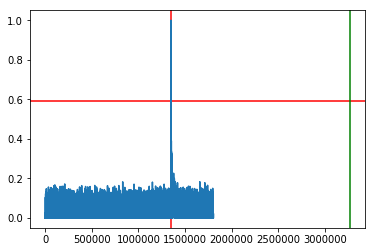

-1 day, 23:59:56.378605
50 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/11/10/20170911101428112_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/11/10/20170911101428112_SVAKOV-R12_raws.fits
delka zaznamu          : 11.600003712 s
cas prvni vzorku s GPS : 5.61519971353 s
cas 1. GPS a konec     : 5.984803998469999 s
SysCas ukladani souboru: 2017-09-11 10:14:28 s
SysCas zacatku souboru : 2017-09-11 10:14:16.399996
SysCas 1. GPS znacky   : 2017-09-11 10:14:22.015196
Korekce systémoveho čas: -1 day, 23:59:57.984804
CorCas ukladani souboru: 2017-09-11 10:14:25.984804 s
CorCas zacatku souboru : 2017-09-11 10:14:14.384800
CorCas 1. GPS znacky   : 2017-09-11 10:14:20


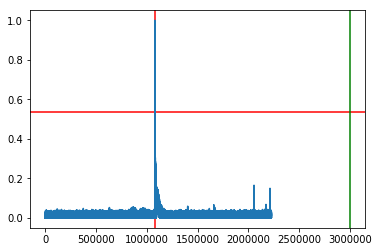

-1 day, 23:59:57.984804
51 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/11/09/20170911094728315_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/11/09/20170911094728315_SVAKOV-R12_raws.fits
delka zaznamu          : 9.600003072 s
cas prvni vzorku s GPS : 5.31563711767 s
cas 1. GPS a konec     : 4.28436595433 s
SysCas ukladani souboru: 2017-09-11 09:47:28 s
SysCas zacatku souboru : 2017-09-11 09:47:18.399997
SysCas 1. GPS znacky   : 2017-09-11 09:47:23.715634
Korekce systémoveho čas: -1 day, 23:59:56.284366
CorCas ukladani souboru: 2017-09-11 09:47:24.284366 s
CorCas zacatku souboru : 2017-09-11 09:47:14.684363
CorCas 1. GPS znacky   : 2017-09-11 09:47:20


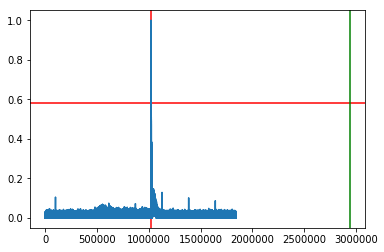

-1 day, 23:59:56.284366
52 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/11/09/20170911092026981_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/11/09/20170911092026981_SVAKOV-R12_raws.fits
delka zaznamu          : 11.600003712 s
cas prvni vzorku s GPS : 6.65585629654 s
cas 1. GPS a konec     : 4.94414741546 s
SysCas ukladani souboru: 2017-09-11 09:20:26 s
SysCas zacatku souboru : 2017-09-11 09:20:14.399996
SysCas 1. GPS znacky   : 2017-09-11 09:20:21.055853
Korekce systémoveho čas: -1 day, 23:59:58.944147
CorCas ukladani souboru: 2017-09-11 09:20:24.944147 s
CorCas zacatku souboru : 2017-09-11 09:20:13.344143
CorCas 1. GPS znacky   : 2017-09-11 09:20:20


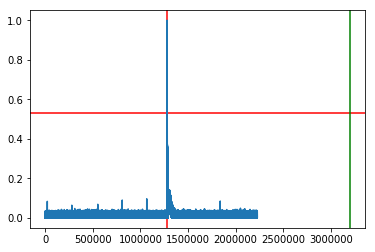

-1 day, 23:59:58.944147
53 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/11/08/20170911085511291_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/11/08/20170911085511291_SVAKOV-R12_raws.fits
delka zaznamu          : 11.00000352 s
cas prvni vzorku s GPS : 2.33601116419 s
cas 1. GPS a konec     : 8.66399235581 s
SysCas ukladani souboru: 2017-09-11 08:55:11 s
SysCas zacatku souboru : 2017-09-11 08:54:59.999996
SysCas 1. GPS znacky   : 2017-09-11 08:55:02.336008
Korekce systémoveho čas: -1 day, 23:59:57.663992
CorCas ukladani souboru: 2017-09-11 08:55:08.663992 s
CorCas zacatku souboru : 2017-09-11 08:54:57.663988
CorCas 1. GPS znacky   : 2017-09-11 08:55:00


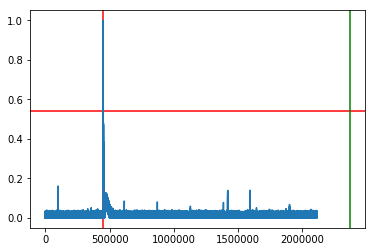

-1 day, 23:59:57.663992
54 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/11/07/20170911073305168_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/11/07/20170911073305168_SVAKOV-R12_raws.fits
delka zaznamu          : 9.600003072 s
cas prvni vzorku s GPS : 8.08183591952 s
cas 1. GPS a konec     : 1.5181671524800002 s
SysCas ukladani souboru: 2017-09-11 07:33:05 s
SysCas zacatku souboru : 2017-09-11 07:32:55.399997
SysCas 1. GPS znacky   : 2017-09-11 07:33:03.481833
Korekce systémoveho čas: -1 day, 23:59:56.518167
CorCas ukladani souboru: 2017-09-11 07:33:01.518167 s
CorCas zacatku souboru : 2017-09-11 07:32:51.918164
CorCas 1. GPS znacky   : 2017-09-11 07:33:00


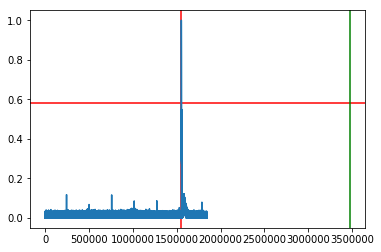

-1 day, 23:59:56.518167
55 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/11/07/20170911071506896_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/11/07/20170911071506896_SVAKOV-R12_raws.fits
delka zaznamu          : 9.600003072 s
cas prvni vzorku s GPS : 6.382564542419999 s
cas 1. GPS a konec     : 3.2174385295800008 s
SysCas ukladani souboru: 2017-09-11 07:15:06 s
SysCas zacatku souboru : 2017-09-11 07:14:56.399997
SysCas 1. GPS znacky   : 2017-09-11 07:15:02.782561
Korekce systémoveho čas: -1 day, 23:59:57.217439
CorCas ukladani souboru: 2017-09-11 07:15:03.217439 s
CorCas zacatku souboru : 2017-09-11 07:14:53.617436
CorCas 1. GPS znacky   : 2017-09-11 07:15:00


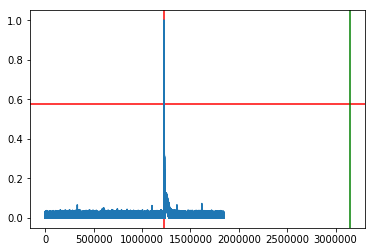

-1 day, 23:59:57.217439
56 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/11/07/20170911071455632_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/11/07/20170911071455632_SVAKOV-R12_raws.fits
delka zaznamu          : 13.000004159999998 s
cas prvni vzorku s GPS : 7.64674203029 s
cas 1. GPS a konec     : 5.353262129709997 s
SysCas ukladani souboru: 2017-09-11 07:14:55 s
SysCas zacatku souboru : 2017-09-11 07:14:41.999996
SysCas 1. GPS znacky   : 2017-09-11 07:14:49.646738
Korekce systémoveho čas: 0:00:00.353262
CorCas ukladani souboru: 2017-09-11 07:14:55.353262 s
CorCas zacatku souboru : 2017-09-11 07:14:42.353258
CorCas 1. GPS znacky   : 2017-09-11 07:14:50


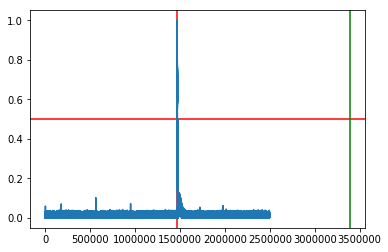

0:00:00.353262
57 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/11/06/20170911063755259_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/11/06/20170911063755259_SVAKOV-R12_raws.fits
delka zaznamu          : 27.600008832 s
cas prvni vzorku s GPS : 7.95870046345 s
cas 1. GPS a konec     : 19.64130836855 s
SysCas ukladani souboru: 2017-09-11 06:37:55 s
SysCas zacatku souboru : 2017-09-11 06:37:27.399991
SysCas 1. GPS znacky   : 2017-09-11 06:37:35.358692
Korekce systémoveho čas: 0:00:04.641308
CorCas ukladani souboru: 2017-09-11 06:37:59.641308 s
CorCas zacatku souboru : 2017-09-11 06:37:32.041299
CorCas 1. GPS znacky   : 2017-09-11 06:37:40


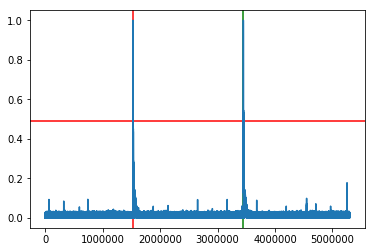

0:00:04.641308
58 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/11/04/20170911045032592_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/11/04/20170911045032592_SVAKOV-R12_raws.fits
delka zaznamu          : 14.200004543999999 s
cas prvni vzorku s GPS : 0.38021887167 s
cas 1. GPS a konec     : 13.81978567233 s
SysCas ukladani souboru: 2017-09-11 04:50:32 s
SysCas zacatku souboru : 2017-09-11 04:50:17.799995
SysCas 1. GPS znacky   : 2017-09-11 04:50:18.180214
Korekce systémoveho čas: 0:00:01.819786
CorCas ukladani souboru: 2017-09-11 04:50:33.819786 s
CorCas zacatku souboru : 2017-09-11 04:50:19.619781
CorCas 1. GPS znacky   : 2017-09-11 04:50:20


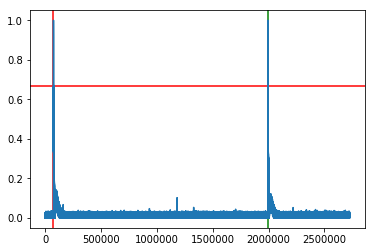

0:00:01.819786
59 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/11/00/20170911005204923_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/11/00/20170911005204923_SVAKOV-R12_raws.fits
delka zaznamu          : 11.400003648 s
cas prvni vzorku s GPS : 7.452044051319999 s
cas 1. GPS a konec     : 3.9479595966800014 s
SysCas ukladani souboru: 2017-09-11 00:52:04 s
SysCas zacatku souboru : 2017-09-11 00:51:52.599996
SysCas 1. GPS znacky   : 2017-09-11 00:52:00.052040
Korekce systémoveho čas: -1 day, 23:59:59.947960
CorCas ukladani souboru: 2017-09-11 00:52:03.947960 s
CorCas zacatku souboru : 2017-09-11 00:51:52.547956
CorCas 1. GPS znacky   : 2017-09-11 00:52:00


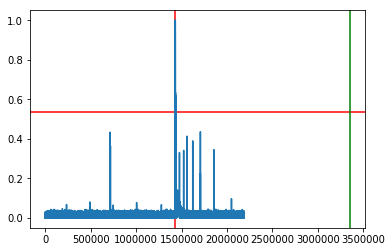

-1 day, 23:59:59.947960
60 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/11/00/20170911001312933_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/11/00/20170911001312933_SVAKOV-R12_raws.fits
delka zaznamu          : 22.600007232 s
cas prvni vzorku s GPS : 9.278534219129998 s
cas 1. GPS a konec     : 13.321473012870001 s
SysCas ukladani souboru: 2017-09-11 00:13:12 s
SysCas zacatku souboru : 2017-09-11 00:12:49.399993
SysCas 1. GPS znacky   : 2017-09-11 00:12:58.678527
Korekce systémoveho čas: 0:00:01.321473
CorCas ukladani souboru: 2017-09-11 00:13:13.321473 s
CorCas zacatku souboru : 2017-09-11 00:12:50.721466
CorCas 1. GPS znacky   : 2017-09-11 00:13:00


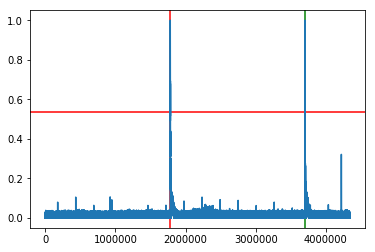

0:00:01.321473
61 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/22/20170910223943291_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/22/20170910223943291_SVAKOV-R12_raws.fits
delka zaznamu          : 36.200011584 s
cas prvni vzorku s GPS : 0.25723966565 s
cas 1. GPS a konec     : 35.942771918350005 s
SysCas ukladani souboru: 2017-09-10 22:39:43 s
SysCas zacatku souboru : 2017-09-10 22:39:06.799988
SysCas 1. GPS znacky   : 2017-09-10 22:39:07.057228
Korekce systémoveho čas: 0:00:02.942772
CorCas ukladani souboru: 2017-09-10 22:39:45.942772 s
CorCas zacatku souboru : 2017-09-10 22:39:09.742760
CorCas 1. GPS znacky   : 2017-09-10 22:39:10


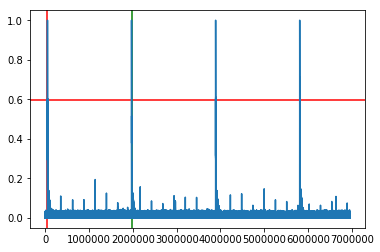

0:00:02.942772
62 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/15/20170910150754768_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/15/20170910150754768_SVAKOV-R12_raws.fits
delka zaznamu          : 9.800003135999999 s
cas prvni vzorku s GPS : 4.04586587801 s
cas 1. GPS a konec     : 5.754137257989999 s
SysCas ukladani souboru: 2017-09-10 15:07:54 s
SysCas zacatku souboru : 2017-09-10 15:07:44.199997
SysCas 1. GPS znacky   : 2017-09-10 15:07:48.245863
Korekce systémoveho čas: 0:00:01.754137
CorCas ukladani souboru: 2017-09-10 15:07:55.754137 s
CorCas zacatku souboru : 2017-09-10 15:07:45.954134
CorCas 1. GPS znacky   : 2017-09-10 15:07:50


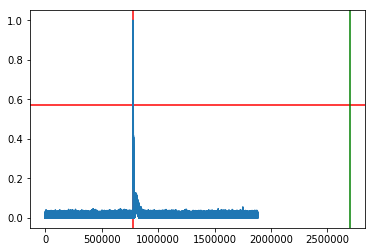

0:00:01.754137
63 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/14/20170910141158267_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/14/20170910141158267_SVAKOV-R12_raws.fits
delka zaznamu          : 10.600003391999998 s
cas prvni vzorku s GPS : 2.1707611113099996 s
cas 1. GPS a konec     : 8.429242280689998 s
SysCas ukladani souboru: 2017-09-10 14:11:58 s
SysCas zacatku souboru : 2017-09-10 14:11:47.399997
SysCas 1. GPS znacky   : 2017-09-10 14:11:49.570758
Korekce systémoveho čas: 0:00:00.429242
CorCas ukladani souboru: 2017-09-10 14:11:58.429242 s
CorCas zacatku souboru : 2017-09-10 14:11:47.829239
CorCas 1. GPS znacky   : 2017-09-10 14:11:50


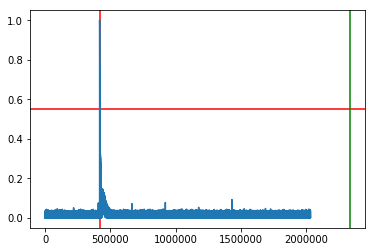

0:00:00.429242
64 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/11/20170910112419856_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/11/20170910112419856_SVAKOV-R12_raws.fits
delka zaznamu          : 10.000003199999998 s
cas prvni vzorku s GPS : 5.625553883509999 s
cas 1. GPS a konec     : 4.374449316489999 s
SysCas ukladani souboru: 2017-09-10 11:24:19 s
SysCas zacatku souboru : 2017-09-10 11:24:08.999997
SysCas 1. GPS znacky   : 2017-09-10 11:24:14.625551
Korekce systémoveho čas: -1 day, 23:59:55.374449
CorCas ukladani souboru: 2017-09-10 11:24:14.374449 s
CorCas zacatku souboru : 2017-09-10 11:24:04.374446
CorCas 1. GPS znacky   : 2017-09-10 11:24:10


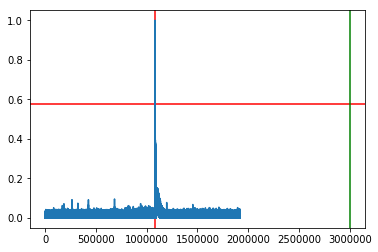

-1 day, 23:59:55.374449
65 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/11/20170910111009083_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/11/20170910111009083_SVAKOV-R12_raws.fits
delka zaznamu          : 10.800003455999999 s
cas prvni vzorku s GPS : 6.785335504639999 s
cas 1. GPS a konec     : 4.01466795136 s
SysCas ukladani souboru: 2017-09-10 11:10:09 s
SysCas zacatku souboru : 2017-09-10 11:09:58.199997
SysCas 1. GPS znacky   : 2017-09-10 11:10:04.985332
Korekce systémoveho čas: -1 day, 23:59:55.014668
CorCas ukladani souboru: 2017-09-10 11:10:04.014668 s
CorCas zacatku souboru : 2017-09-10 11:09:53.214665
CorCas 1. GPS znacky   : 2017-09-10 11:10:00


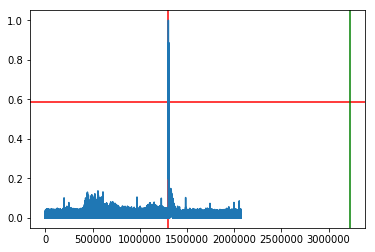

-1 day, 23:59:55.014668
66 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/10/20170910105305083_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/10/20170910105305083_SVAKOV-R12_raws.fits
delka zaznamu          : 9.400003008 s
cas prvni vzorku s GPS : 1.3829171091999999 s
cas 1. GPS a konec     : 8.017085898800001 s
SysCas ukladani souboru: 2017-09-10 10:53:05 s
SysCas zacatku souboru : 2017-09-10 10:52:55.599997
SysCas 1. GPS znacky   : 2017-09-10 10:52:56.982914
Korekce systémoveho čas: 0:00:03.017086
CorCas ukladani souboru: 2017-09-10 10:53:08.017086 s
CorCas zacatku souboru : 2017-09-10 10:52:58.617083
CorCas 1. GPS znacky   : 2017-09-10 10:53:00


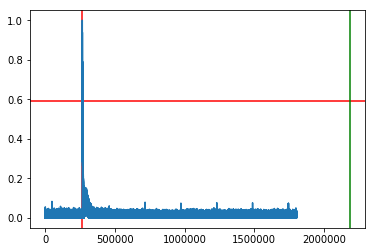

0:00:03.017086
67 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/08/20170910084746363_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/08/20170910084746363_SVAKOV-R12_raws.fits
delka zaznamu          : 22.800007296 s
cas prvni vzorku s GPS : 4.47776184955 s
cas 1. GPS a konec     : 18.32224544645 s
SysCas ukladani souboru: 2017-09-10 08:47:46 s
SysCas zacatku souboru : 2017-09-10 08:47:23.199993
SysCas 1. GPS znacky   : 2017-09-10 08:47:27.677755
Korekce systémoveho čas: 0:00:02.322245
CorCas ukladani souboru: 2017-09-10 08:47:48.322245 s
CorCas zacatku souboru : 2017-09-10 08:47:25.522238
CorCas 1. GPS znacky   : 2017-09-10 08:47:30


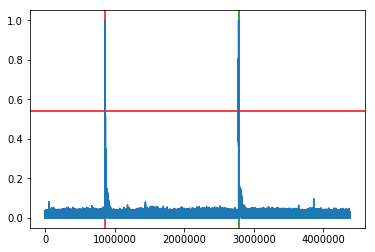

0:00:02.322245
68 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/08/20170910082224016_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/08/20170910082224016_SVAKOV-R12_raws.fits
delka zaznamu          : 30.0000096 s
cas prvni vzorku s GPS : 7.6803462077099995 s
cas 1. GPS a konec     : 22.31966339229 s
SysCas ukladani souboru: 2017-09-10 08:22:24 s
SysCas zacatku souboru : 2017-09-10 08:21:53.999990
SysCas 1. GPS znacky   : 2017-09-10 08:22:01.680337
Korekce systémoveho čas: -1 day, 23:59:58.319663
CorCas ukladani souboru: 2017-09-10 08:22:22.319663 s
CorCas zacatku souboru : 2017-09-10 08:21:52.319653
CorCas 1. GPS znacky   : 2017-09-10 08:22:00


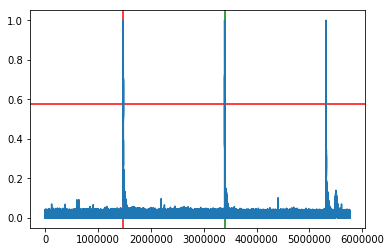

-1 day, 23:59:58.319663
69 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/07/20170910072641851_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/07/20170910072641851_SVAKOV-R12_raws.fits
delka zaznamu          : 10.600003391999998 s
cas prvni vzorku s GPS : 1.49155256063 s
cas 1. GPS a konec     : 9.108450831369998 s
SysCas ukladani souboru: 2017-09-10 07:26:41 s
SysCas zacatku souboru : 2017-09-10 07:26:30.399997
SysCas 1. GPS znacky   : 2017-09-10 07:26:31.891549
Korekce systémoveho čas: -1 day, 23:59:58.108451
CorCas ukladani souboru: 2017-09-10 07:26:39.108451 s
CorCas zacatku souboru : 2017-09-10 07:26:28.508448
CorCas 1. GPS znacky   : 2017-09-10 07:26:30


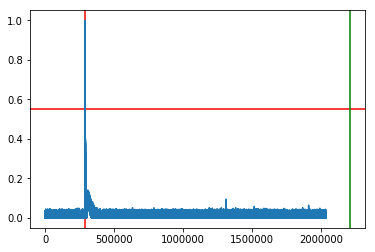

-1 day, 23:59:58.108451
70 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/06/20170910065530149_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/06/20170910065530149_SVAKOV-R12_raws.fits
delka zaznamu          : 9.19999252733 s
cas prvni vzorku s GPS : 4.34466805696 s
cas 1. GPS a konec     : 4.85532447037 s
SysCas ukladani souboru: 2017-09-10 06:55:30 s
SysCas zacatku souboru : 2017-09-10 06:55:20.800007
SysCas 1. GPS znacky   : 2017-09-10 06:55:25.144676
Korekce systémoveho čas: 0:00:04.855324
CorCas ukladani souboru: 2017-09-10 06:55:34.855324 s
CorCas zacatku souboru : 2017-09-10 06:55:25.655331
CorCas 1. GPS znacky   : 2017-09-10 06:55:30


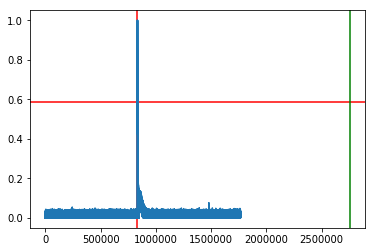

0:00:04.855324
71 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/06/20170910065519227_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/06/20170910065519227_SVAKOV-R12_raws.fits
delka zaznamu          : 9.600003072 s
cas prvni vzorku s GPS : 5.27548085482 s
cas 1. GPS a konec     : 4.32452221718 s
SysCas ukladani souboru: 2017-09-10 06:55:19 s
SysCas zacatku souboru : 2017-09-10 06:55:09.399997
SysCas 1. GPS znacky   : 2017-09-10 06:55:14.675478
Korekce systémoveho čas: -1 day, 23:59:55.324522
CorCas ukladani souboru: 2017-09-10 06:55:14.324522 s
CorCas zacatku souboru : 2017-09-10 06:55:04.724519
CorCas 1. GPS znacky   : 2017-09-10 06:55:10


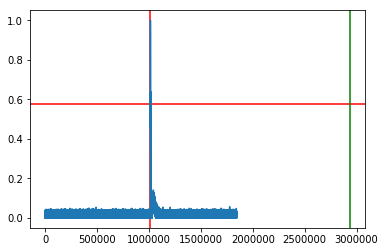

-1 day, 23:59:55.324522
72 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/06/20170910061534843_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/06/20170910061534843_SVAKOV-R12_raws.fits
delka zaznamu          : 11.200003584 s
cas prvni vzorku s GPS : 0.91795862708 s
cas 1. GPS a konec     : 10.28204495692 s
SysCas ukladani souboru: 2017-09-10 06:15:34 s
SysCas zacatku souboru : 2017-09-10 06:15:22.799996
SysCas 1. GPS znacky   : 2017-09-10 06:15:23.717955
Korekce systémoveho čas: -1 day, 23:59:56.282045
CorCas ukladani souboru: 2017-09-10 06:15:30.282045 s
CorCas zacatku souboru : 2017-09-10 06:15:19.082041
CorCas 1. GPS znacky   : 2017-09-10 06:15:20


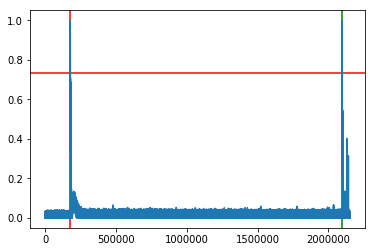

-1 day, 23:59:56.282045
73 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/04/20170910043937061_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/04/20170910043937061_SVAKOV-R12_raws.fits
delka zaznamu          : 16.399994831329998 s
cas prvni vzorku s GPS : 1.8039589105999998 s
cas 1. GPS a konec     : 14.596035920729998 s
SysCas ukladani souboru: 2017-09-10 04:39:37 s
SysCas zacatku souboru : 2017-09-10 04:39:20.600005
SysCas 1. GPS znacky   : 2017-09-10 04:39:22.403964
Korekce systémoveho čas: -1 day, 23:59:57.596036
CorCas ukladani souboru: 2017-09-10 04:39:34.596036 s
CorCas zacatku souboru : 2017-09-10 04:39:18.196041
CorCas 1. GPS znacky   : 2017-09-10 04:39:20


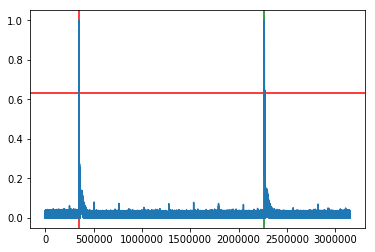

-1 day, 23:59:57.596036
74 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/04/20170910042301221_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/04/20170910042301221_SVAKOV-R12_raws.fits
delka zaznamu          : 19.800006336 s
cas prvni vzorku s GPS : 8.0889609218 s
cas 1. GPS a konec     : 11.7110454142 s
SysCas ukladani souboru: 2017-09-10 04:23:01 s
SysCas zacatku souboru : 2017-09-10 04:22:41.199994
SysCas 1. GPS znacky   : 2017-09-10 04:22:49.288955
Korekce systémoveho čas: 0:00:00.711045
CorCas ukladani souboru: 2017-09-10 04:23:01.711045 s
CorCas zacatku souboru : 2017-09-10 04:22:41.911039
CorCas 1. GPS znacky   : 2017-09-10 04:22:50


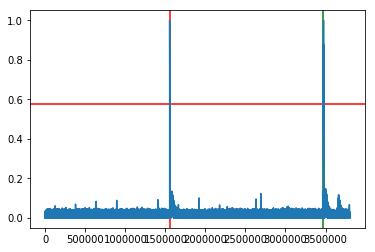

0:00:00.711045
75 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/04/20170910041822523_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/04/20170910041822523_SVAKOV-R12_raws.fits
delka zaznamu          : 26.400008447999998 s
cas prvni vzorku s GPS : 6.9454605558799996 s
cas 1. GPS a konec     : 19.454547892119997 s
SysCas ukladani souboru: 2017-09-10 04:18:22 s
SysCas zacatku souboru : 2017-09-10 04:17:55.599992
SysCas 1. GPS znacky   : 2017-09-10 04:18:02.545452
Korekce systémoveho čas: -1 day, 23:59:57.454548
CorCas ukladani souboru: 2017-09-10 04:18:19.454548 s
CorCas zacatku souboru : 2017-09-10 04:17:53.054540
CorCas 1. GPS znacky   : 2017-09-10 04:18:00


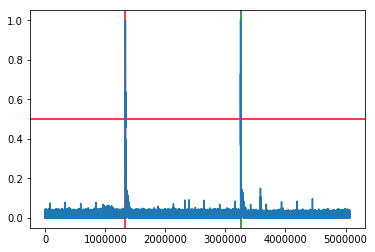

-1 day, 23:59:57.454548
76 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/03/20170910034509648_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/03/20170910034509648_SVAKOV-R12_raws.fits
delka zaznamu          : 11.800003775999999 s
cas prvni vzorku s GPS : 0.86954194492 s
cas 1. GPS a konec     : 10.930461831079999 s
SysCas ukladani souboru: 2017-09-10 03:45:09 s
SysCas zacatku souboru : 2017-09-10 03:44:57.199996
SysCas 1. GPS znacky   : 2017-09-10 03:44:58.069538
Korekce systémoveho čas: 0:00:01.930462
CorCas ukladani souboru: 2017-09-10 03:45:10.930462 s
CorCas zacatku souboru : 2017-09-10 03:44:59.130458
CorCas 1. GPS znacky   : 2017-09-10 03:45:00


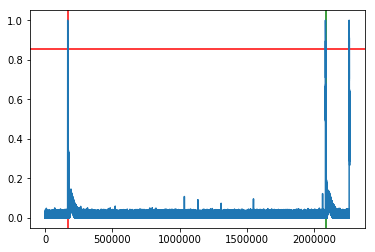

0:00:01.930462
77 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/03/20170910033602832_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/03/20170910033602832_SVAKOV-R12_raws.fits
delka zaznamu          : 13.600004352 s
cas prvni vzorku s GPS : 8.01683589872 s
cas 1. GPS a konec     : 5.583168453279999 s
SysCas ukladani souboru: 2017-09-10 03:36:02 s
SysCas zacatku souboru : 2017-09-10 03:35:48.399996
SysCas 1. GPS znacky   : 2017-09-10 03:35:56.416832
Korekce systémoveho čas: 0:00:03.583168
CorCas ukladani souboru: 2017-09-10 03:36:05.583168 s
CorCas zacatku souboru : 2017-09-10 03:35:51.983164
CorCas 1. GPS znacky   : 2017-09-10 03:36:00


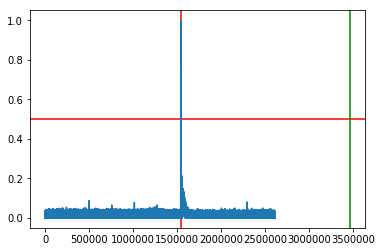

0:00:03.583168
78 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/02/20170910021424016_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/02/20170910021424016_SVAKOV-R12_raws.fits
delka zaznamu          : 13.000004159999998 s
cas prvni vzorku s GPS : 9.527753048880001 s
cas 1. GPS a konec     : 3.4722511111199967 s
SysCas ukladani souboru: 2017-09-10 02:14:24 s
SysCas zacatku souboru : 2017-09-10 02:14:10.999996
SysCas 1. GPS znacky   : 2017-09-10 02:14:20.527749
Korekce systémoveho čas: -1 day, 23:59:59.472251
CorCas ukladani souboru: 2017-09-10 02:14:23.472251 s
CorCas zacatku souboru : 2017-09-10 02:14:10.472247
CorCas 1. GPS znacky   : 2017-09-10 02:14:20


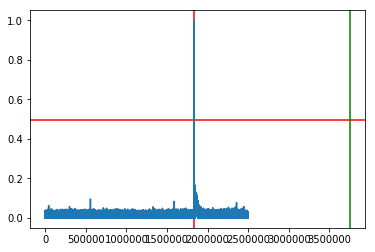

-1 day, 23:59:59.472251
79 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/01/20170910015502629_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/01/20170910015502629_SVAKOV-R12_raws.fits
delka zaznamu          : 12.00000384 s
cas prvni vzorku s GPS : 1.54675049496 s
cas 1. GPS a konec     : 10.45325334504 s
SysCas ukladani souboru: 2017-09-10 01:55:02 s
SysCas zacatku souboru : 2017-09-10 01:54:49.999996
SysCas 1. GPS znacky   : 2017-09-10 01:54:51.546747
Korekce systémoveho čas: -1 day, 23:59:58.453253
CorCas ukladani souboru: 2017-09-10 01:55:00.453253 s
CorCas zacatku souboru : 2017-09-10 01:54:48.453249
CorCas 1. GPS znacky   : 2017-09-10 01:54:50


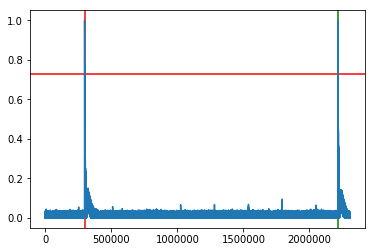

-1 day, 23:59:58.453253
80 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/01/20170910011252667_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/10/01/20170910011252667_SVAKOV-R12_raws.fits
delka zaznamu          : 9.19999252733 s
cas prvni vzorku s GPS : 2.8668550840599996 s
cas 1. GPS a konec     : 6.333137443270001 s
SysCas ukladani souboru: 2017-09-10 01:12:52 s
SysCas zacatku souboru : 2017-09-10 01:12:42.800007
SysCas 1. GPS znacky   : 2017-09-10 01:12:45.666863
Korekce systémoveho čas: 0:00:04.333137
CorCas ukladani souboru: 2017-09-10 01:12:56.333137 s
CorCas zacatku souboru : 2017-09-10 01:12:47.133144
CorCas 1. GPS znacky   : 2017-09-10 01:12:50


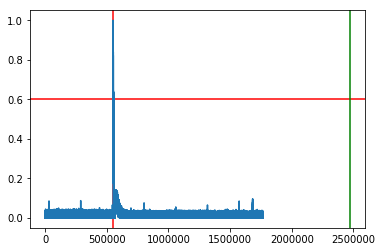

0:00:04.333137
81 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/23/20170909235729659_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/23/20170909235729659_SVAKOV-R12_raws.fits
delka zaznamu          : 18.600005952 s
cas prvni vzorku s GPS : 7.890429608269999 s
cas 1. GPS a konec     : 10.709576343730001 s
SysCas ukladani souboru: 2017-09-09 23:57:29 s
SysCas zacatku souboru : 2017-09-09 23:57:10.399994
SysCas 1. GPS znacky   : 2017-09-09 23:57:18.290424
Korekce systémoveho čas: 0:00:01.709576
CorCas ukladani souboru: 2017-09-09 23:57:30.709576 s
CorCas zacatku souboru : 2017-09-09 23:57:12.109570
CorCas 1. GPS znacky   : 2017-09-09 23:57:20


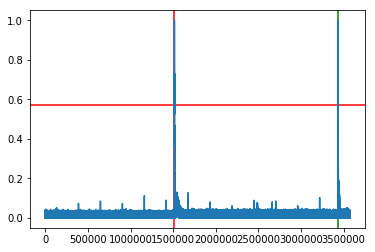

0:00:01.709576
82 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/23/20170909235627536_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/23/20170909235627536_SVAKOV-R12_raws.fits
delka zaznamu          : 17.39999515133 s
cas prvni vzorku s GPS : 0.03043750974 s
cas 1. GPS a konec     : 17.36955764159 s
SysCas ukladani souboru: 2017-09-09 23:56:27 s
SysCas zacatku souboru : 2017-09-09 23:56:09.600005
SysCas 1. GPS znacky   : 2017-09-09 23:56:09.630442
Korekce systémoveho čas: 0:00:00.369558
CorCas ukladani souboru: 2017-09-09 23:56:27.369558 s
CorCas zacatku souboru : 2017-09-09 23:56:09.969563
CorCas 1. GPS znacky   : 2017-09-09 23:56:10


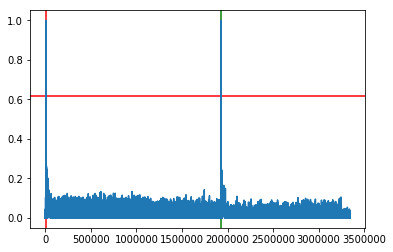

0:00:00.369558
83 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/17/20170909172041317_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/17/20170909172041317_SVAKOV-R12_raws.fits
delka zaznamu          : 14.400004608 s
cas prvni vzorku s GPS : 2.0536464905 s
cas 1. GPS a konec     : 12.3463581175 s
SysCas ukladani souboru: 2017-09-09 17:20:41 s
SysCas zacatku souboru : 2017-09-09 17:20:26.599995
SysCas 1. GPS znacky   : 2017-09-09 17:20:28.653642
Korekce systémoveho čas: 0:00:01.346358
CorCas ukladani souboru: 2017-09-09 17:20:42.346358 s
CorCas zacatku souboru : 2017-09-09 17:20:27.946353
CorCas 1. GPS znacky   : 2017-09-09 17:20:30


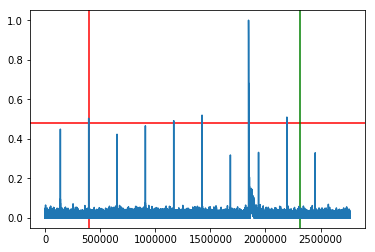

0:00:01.346358
84 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/16/20170909162840507_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/16/20170909162840507_SVAKOV-R12_raws.fits
delka zaznamu          : 14.600004671999999 s
cas prvni vzorku s GPS : 2.1468756869999996 s
cas 1. GPS a konec     : 12.453128985 s
SysCas ukladani souboru: 2017-09-09 16:28:40 s
SysCas zacatku souboru : 2017-09-09 16:28:25.399995
SysCas 1. GPS znacky   : 2017-09-09 16:28:27.546871
Korekce systémoveho čas: 0:00:02.453129
CorCas ukladani souboru: 2017-09-09 16:28:42.453129 s
CorCas zacatku souboru : 2017-09-09 16:28:27.853124
CorCas 1. GPS znacky   : 2017-09-09 16:28:30


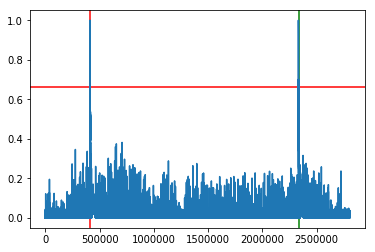

0:00:02.453129
85 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/15/20170909153421797_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/15/20170909153421797_SVAKOV-R12_raws.fits
delka zaznamu          : 9.19999252733 s
cas prvni vzorku s GPS : 2.7809383898999998 s
cas 1. GPS a konec     : 6.419054137430001 s
SysCas ukladani souboru: 2017-09-09 15:34:21 s
SysCas zacatku souboru : 2017-09-09 15:34:11.800007
SysCas 1. GPS znacky   : 2017-09-09 15:34:14.580946
Korekce systémoveho čas: -1 day, 23:59:55.419054
CorCas ukladani souboru: 2017-09-09 15:34:16.419054 s
CorCas zacatku souboru : 2017-09-09 15:34:07.219061
CorCas 1. GPS znacky   : 2017-09-09 15:34:10


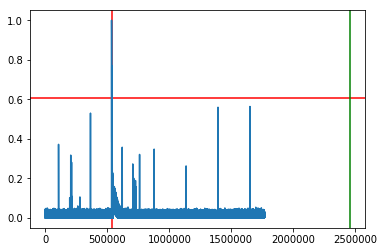

-1 day, 23:59:55.419054
86 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/15/20170909152604304_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/15/20170909152604304_SVAKOV-R12_raws.fits
delka zaznamu          : 11.200003584 s
cas prvni vzorku s GPS : 0.55675017816 s
cas 1. GPS a konec     : 10.64325340584 s
SysCas ukladani souboru: 2017-09-09 15:26:04 s
SysCas zacatku souboru : 2017-09-09 15:25:52.799996
SysCas 1. GPS znacky   : 2017-09-09 15:25:53.356747
Korekce systémoveho čas: -1 day, 23:59:56.643253
CorCas ukladani souboru: 2017-09-09 15:26:00.643253 s
CorCas zacatku souboru : 2017-09-09 15:25:49.443249
CorCas 1. GPS znacky   : 2017-09-09 15:25:50


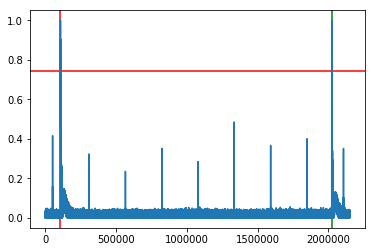

-1 day, 23:59:56.643253
87 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/13/20170909133155109_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/13/20170909133155109_SVAKOV-R12_raws.fits
delka zaznamu          : 9.600003072 s
cas prvni vzorku s GPS : 3.41669901001 s
cas 1. GPS a konec     : 6.18330406199 s
SysCas ukladani souboru: 2017-09-09 13:31:55 s
SysCas zacatku souboru : 2017-09-09 13:31:45.399997
SysCas 1. GPS znacky   : 2017-09-09 13:31:48.816696
Korekce systémoveho čas: 0:00:01.183304
CorCas ukladani souboru: 2017-09-09 13:31:56.183304 s
CorCas zacatku souboru : 2017-09-09 13:31:46.583301
CorCas 1. GPS znacky   : 2017-09-09 13:31:50


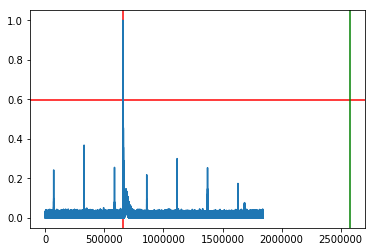

0:00:01.183304
88 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/08/20170909084214245_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/08/20170909084214245_SVAKOV-R12_raws.fits
delka zaznamu          : 10.199992847329998 s
cas prvni vzorku s GPS : 3.7589803695399997 s
cas 1. GPS a konec     : 6.441012477789998 s
SysCas ukladani souboru: 2017-09-09 08:42:14 s
SysCas zacatku souboru : 2017-09-09 08:42:03.800007
SysCas 1. GPS znacky   : 2017-09-09 08:42:07.558988
Korekce systémoveho čas: 0:00:02.441012
CorCas ukladani souboru: 2017-09-09 08:42:16.441012 s
CorCas zacatku souboru : 2017-09-09 08:42:06.241019
CorCas 1. GPS znacky   : 2017-09-09 08:42:10


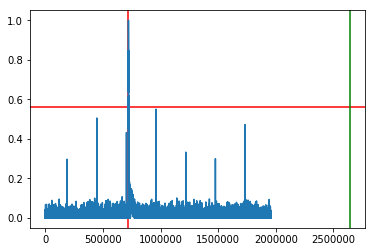

0:00:02.441012
89 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/07/20170909074135632_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/07/20170909074135632_SVAKOV-R12_raws.fits
delka zaznamu          : 26.600008511999995 s
cas prvni vzorku s GPS : 4.12814715434 s
cas 1. GPS a konec     : 22.471861357659996 s
SysCas ukladani souboru: 2017-09-09 07:41:35 s
SysCas zacatku souboru : 2017-09-09 07:41:08.399991
SysCas 1. GPS znacky   : 2017-09-09 07:41:12.528139
Korekce systémoveho čas: -1 day, 23:59:57.471861
CorCas ukladani souboru: 2017-09-09 07:41:32.471861 s
CorCas zacatku souboru : 2017-09-09 07:41:05.871852
CorCas 1. GPS znacky   : 2017-09-09 07:41:10


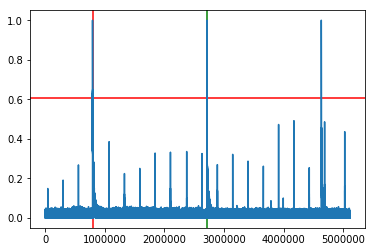

-1 day, 23:59:57.471861
90 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/06/20170909063359739_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/06/20170909063359739_SVAKOV-R12_raws.fits
delka zaznamu          : 14.200004543999999 s
cas prvni vzorku s GPS : 2.46706328946 s
cas 1. GPS a konec     : 11.732941254539998 s
SysCas ukladani souboru: 2017-09-09 06:33:59 s
SysCas zacatku souboru : 2017-09-09 06:33:44.799995
SysCas 1. GPS znacky   : 2017-09-09 06:33:47.267059
Korekce systémoveho čas: 0:00:02.732941
CorCas ukladani souboru: 2017-09-09 06:34:01.732941 s
CorCas zacatku souboru : 2017-09-09 06:33:47.532936
CorCas 1. GPS znacky   : 2017-09-09 06:33:50


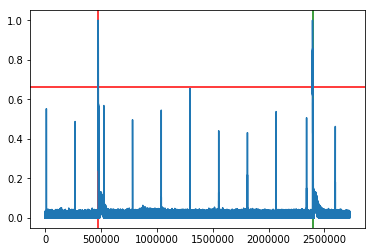

0:00:02.732941
91 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/05/20170909054347984_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/05/20170909054347984_SVAKOV-R12_raws.fits
delka zaznamu          : 20.399996111329997 s
cas prvni vzorku s GPS : 5.77253309721 s
cas 1. GPS a konec     : 14.627463014119996 s
SysCas ukladani souboru: 2017-09-09 05:43:47 s
SysCas zacatku souboru : 2017-09-09 05:43:26.600004
SysCas 1. GPS znacky   : 2017-09-09 05:43:32.372537
Korekce systémoveho čas: -1 day, 23:59:57.627463
CorCas ukladani souboru: 2017-09-09 05:43:44.627463 s
CorCas zacatku souboru : 2017-09-09 05:43:24.227467
CorCas 1. GPS znacky   : 2017-09-09 05:43:30


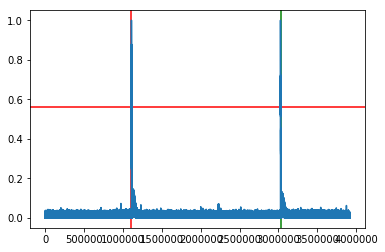

-1 day, 23:59:57.627463
92 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/05/20170909053257061_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/05/20170909053257061_SVAKOV-R12_raws.fits
delka zaznamu          : 10.199992847329998 s
cas prvni vzorku s GPS : 7.053023090299999 s
cas 1. GPS a konec     : 3.146969757029999 s
SysCas ukladani souboru: 2017-09-09 05:32:57 s
SysCas zacatku souboru : 2017-09-09 05:32:46.800007
SysCas 1. GPS znacky   : 2017-09-09 05:32:53.853030
Korekce systémoveho čas: -1 day, 23:59:56.146970
CorCas ukladani souboru: 2017-09-09 05:32:53.146970 s
CorCas zacatku souboru : 2017-09-09 05:32:42.946977
CorCas 1. GPS znacky   : 2017-09-09 05:32:50


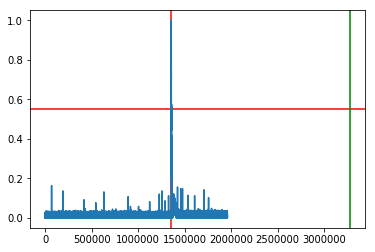

-1 day, 23:59:56.146970
93 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/05/20170909053104251_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/05/20170909053104251_SVAKOV-R12_raws.fits
delka zaznamu          : 9.400003008 s
cas prvni vzorku s GPS : 9.399997799665 s
cas 1. GPS a konec     : 5.208335000617126e-06 s
SysCas ukladani souboru: 2017-09-09 05:31:04 s
SysCas zacatku souboru : 2017-09-09 05:30:54.599997
SysCas 1. GPS znacky   : 2017-09-09 05:31:03.999995
Korekce systémoveho čas: -1 day, 23:59:56.000005
CorCas ukladani souboru: 2017-09-09 05:31:00.000005 s
CorCas zacatku souboru : 2017-09-09 05:30:50.600002
CorCas 1. GPS znacky   : 2017-09-09 05:31:00


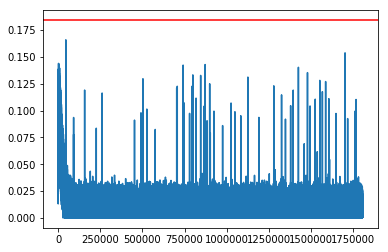

-1 day, 23:59:56.000005
94 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/05/20170909052359461_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/05/20170909052359461_SVAKOV-R12_raws.fits
delka zaznamu          : 9.800003135999999 s
cas prvni vzorku s GPS : 4.9525849181599995 s
cas 1. GPS a konec     : 4.84741821784 s
SysCas ukladani souboru: 2017-09-09 05:23:59 s
SysCas zacatku souboru : 2017-09-09 05:23:49.199997
SysCas 1. GPS znacky   : 2017-09-09 05:23:54.152582
Korekce systémoveho čas: -1 day, 23:59:55.847418
CorCas ukladani souboru: 2017-09-09 05:23:54.847418 s
CorCas zacatku souboru : 2017-09-09 05:23:45.047415
CorCas 1. GPS znacky   : 2017-09-09 05:23:50


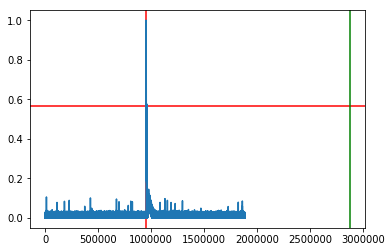

-1 day, 23:59:55.847418
95 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/05/20170909052303141_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/05/20170909052303141_SVAKOV-R12_raws.fits
delka zaznamu          : 11.200003584 s
cas prvni vzorku s GPS : 1.32195875636 s
cas 1. GPS a konec     : 9.87804482764 s
SysCas ukladani souboru: 2017-09-09 05:23:03 s
SysCas zacatku souboru : 2017-09-09 05:22:51.799996
SysCas 1. GPS znacky   : 2017-09-09 05:22:53.121955
Korekce systémoveho čas: -1 day, 23:59:56.878045
CorCas ukladani souboru: 2017-09-09 05:22:59.878045 s
CorCas zacatku souboru : 2017-09-09 05:22:48.678041
CorCas 1. GPS znacky   : 2017-09-09 05:22:50


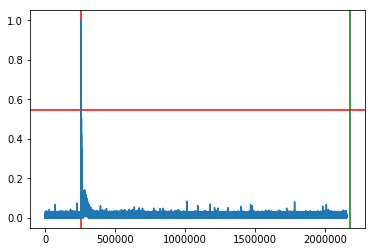

-1 day, 23:59:56.878045
96 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/04/20170909042658960_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/04/20170909042658960_SVAKOV-R12_raws.fits
delka zaznamu          : 16.399994831329998 s
cas prvni vzorku s GPS : 3.3868865004699997 s
cas 1. GPS a konec     : 13.013108330859998 s
SysCas ukladani souboru: 2017-09-09 04:26:58 s
SysCas zacatku souboru : 2017-09-09 04:26:41.600005
SysCas 1. GPS znacky   : 2017-09-09 04:26:44.986892
Korekce systémoveho čas: -1 day, 23:59:55.013108
CorCas ukladani souboru: 2017-09-09 04:26:53.013108 s
CorCas zacatku souboru : 2017-09-09 04:26:36.613113
CorCas 1. GPS znacky   : 2017-09-09 04:26:40


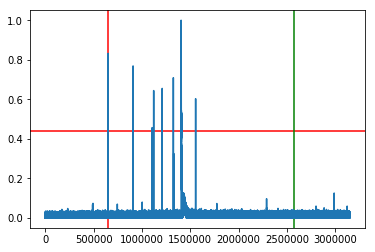

-1 day, 23:59:55.013108
97 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/04/20170909041707600_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/04/20170909041707600_SVAKOV-R12_raws.fits
delka zaznamu          : 13.200004223999999 s
cas prvni vzorku s GPS : 8.92290910533 s
cas 1. GPS a konec     : 4.277095118669999 s
SysCas ukladani souboru: 2017-09-09 04:17:07 s
SysCas zacatku souboru : 2017-09-09 04:16:53.799996
SysCas 1. GPS znacky   : 2017-09-09 04:17:02.722905
Korekce systémoveho čas: -1 day, 23:59:57.277095
CorCas ukladani souboru: 2017-09-09 04:17:04.277095 s
CorCas zacatku souboru : 2017-09-09 04:16:51.077091
CorCas 1. GPS znacky   : 2017-09-09 04:17:00


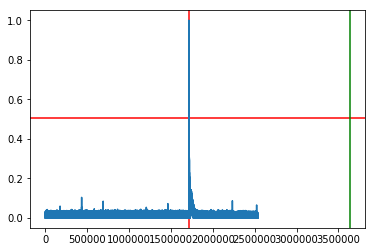

-1 day, 23:59:57.277095
98 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/02/20170909025235728_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/02/20170909025235728_SVAKOV-R12_raws.fits
delka zaznamu          : 15.200004863999999 s
cas prvni vzorku s GPS : 3.4134281756299996 s
cas 1. GPS a konec     : 11.78657668837 s
SysCas ukladani souboru: 2017-09-09 02:52:35 s
SysCas zacatku souboru : 2017-09-09 02:52:19.799995
SysCas 1. GPS znacky   : 2017-09-09 02:52:23.213423
Korekce systémoveho čas: -1 day, 23:59:56.786577
CorCas ukladani souboru: 2017-09-09 02:52:31.786577 s
CorCas zacatku souboru : 2017-09-09 02:52:16.586572
CorCas 1. GPS znacky   : 2017-09-09 02:52:20


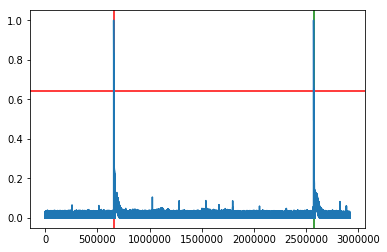

-1 day, 23:59:56.786577
99 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/02/20170909020838757_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/02/20170909020838757_SVAKOV-R12_raws.fits
delka zaznamu          : 30.0000096 s
cas prvni vzorku s GPS : 1.7518755606 s
cas 1. GPS a konec     : 28.2481340394 s
SysCas ukladani souboru: 2017-09-09 02:08:38 s
SysCas zacatku souboru : 2017-09-09 02:08:07.999990
SysCas 1. GPS znacky   : 2017-09-09 02:08:09.751866
Korekce systémoveho čas: 0:00:00.248134
CorCas ukladani souboru: 2017-09-09 02:08:38.248134 s
CorCas zacatku souboru : 2017-09-09 02:08:08.248124
CorCas 1. GPS znacky   : 2017-09-09 02:08:10


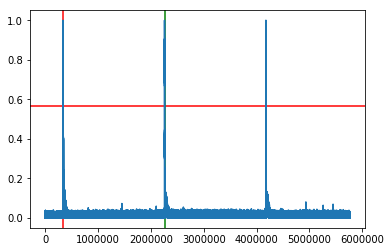

0:00:00.248134
100 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/01/20170909012218939_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/01/20170909012218939_SVAKOV-R12_raws.fits
delka zaznamu          : 11.400003648 s
cas prvni vzorku s GPS : 3.3409177357599997 s
cas 1. GPS a konec     : 8.05908591224 s
SysCas ukladani souboru: 2017-09-09 01:22:18 s
SysCas zacatku souboru : 2017-09-09 01:22:06.599996
SysCas 1. GPS znacky   : 2017-09-09 01:22:09.940914
Korekce systémoveho čas: 0:00:00.059086
CorCas ukladani souboru: 2017-09-09 01:22:18.059086 s
CorCas zacatku souboru : 2017-09-09 01:22:06.659082
CorCas 1. GPS znacky   : 2017-09-09 01:22:10


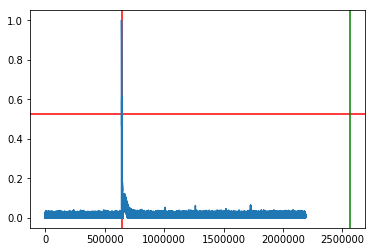

0:00:00.059086
101 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/00/20170909004310053_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/09/00/20170909004310053_SVAKOV-R12_raws.fits
delka zaznamu          : 33.600010751999996 s
cas prvni vzorku s GPS : 3.60255323615 s
cas 1. GPS a konec     : 29.997457515849995 s
SysCas ukladani souboru: 2017-09-09 00:43:10 s
SysCas zacatku souboru : 2017-09-09 00:42:36.399989
SysCas 1. GPS znacky   : 2017-09-09 00:42:40.002542
Korekce systémoveho čas: -1 day, 23:59:59.997458
CorCas ukladani souboru: 2017-09-09 00:43:09.997458 s
CorCas zacatku souboru : 2017-09-09 00:42:36.397447
CorCas 1. GPS znacky   : 2017-09-09 00:42:40


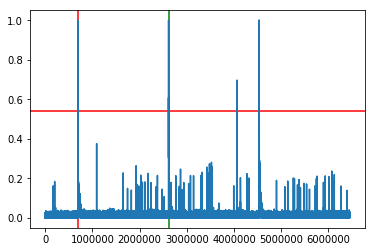

-1 day, 23:59:59.997458
102 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/08/23/20170908230349861_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/08/23/20170908230349861_SVAKOV-R12_raws.fits
delka zaznamu          : 12.200003903999999 s
cas prvni vzorku s GPS : 7.19892938699 s
cas 1. GPS a konec     : 5.001074517009999 s
SysCas ukladani souboru: 2017-09-08 23:03:49 s
SysCas zacatku souboru : 2017-09-08 23:03:36.799996
SysCas 1. GPS znacky   : 2017-09-08 23:03:43.998925
Korekce systémoveho čas: -1 day, 23:59:56.001075
CorCas ukladani souboru: 2017-09-08 23:03:45.001075 s
CorCas zacatku souboru : 2017-09-08 23:03:32.801071
CorCas 1. GPS znacky   : 2017-09-08 23:03:40


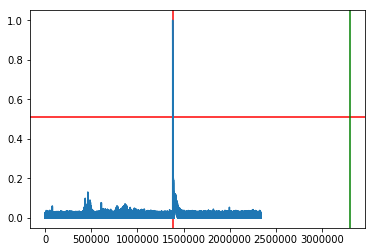

-1 day, 23:59:56.001075
103 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/08/22/20170908221833019_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/08/22/20170908221833019_SVAKOV-R12_raws.fits
delka zaznamu          : 25.600008191999997 s
cas prvni vzorku s GPS : 5.41027256462 s
cas 1. GPS a konec     : 20.189735627379996 s
SysCas ukladani souboru: 2017-09-08 22:18:33 s
SysCas zacatku souboru : 2017-09-08 22:18:07.399992
SysCas 1. GPS znacky   : 2017-09-08 22:18:12.810264
Korekce systémoveho čas: -1 day, 23:59:57.189736
CorCas ukladani souboru: 2017-09-08 22:18:30.189736 s
CorCas zacatku souboru : 2017-09-08 22:18:04.589728
CorCas 1. GPS znacky   : 2017-09-08 22:18:10


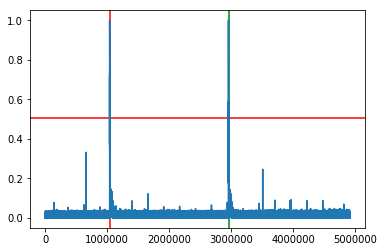

-1 day, 23:59:57.189736
104 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/08/17/20170908170456336_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/08/17/20170908170456336_SVAKOV-R12_raws.fits
delka zaznamu          : 12.600004032 s
cas prvni vzorku s GPS : 3.27444896449 s
cas 1. GPS a konec     : 9.325555067509999 s
SysCas ukladani souboru: 2017-09-08 17:04:56 s
SysCas zacatku souboru : 2017-09-08 17:04:43.399996
SysCas 1. GPS znacky   : 2017-09-08 17:04:46.674445
Korekce systémoveho čas: 0:00:03.325555
CorCas ukladani souboru: 2017-09-08 17:04:59.325555 s
CorCas zacatku souboru : 2017-09-08 17:04:46.725551
CorCas 1. GPS znacky   : 2017-09-08 17:04:50


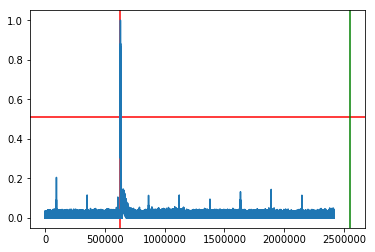

0:00:03.325555
105 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/08/16/20170908163537616_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/08/16/20170908163537616_SVAKOV-R12_raws.fits
delka zaznamu          : 9.600003072 s
cas prvni vzorku s GPS : 2.99118845718 s
cas 1. GPS a konec     : 6.60881461482 s
SysCas ukladani souboru: 2017-09-08 16:35:37 s
SysCas zacatku souboru : 2017-09-08 16:35:27.399997
SysCas 1. GPS znacky   : 2017-09-08 16:35:30.391185
Korekce systémoveho čas: -1 day, 23:59:59.608815
CorCas ukladani souboru: 2017-09-08 16:35:36.608815 s
CorCas zacatku souboru : 2017-09-08 16:35:27.008812
CorCas 1. GPS znacky   : 2017-09-08 16:35:30


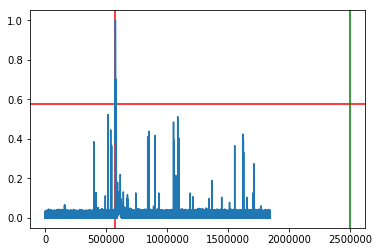

-1 day, 23:59:59.608815
106 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/08/16/20170908163059088_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/08/16/20170908163059088_SVAKOV-R12_raws.fits
delka zaznamu          : 21.200006783999996 s
cas prvni vzorku s GPS : 1.68491720584 s
cas 1. GPS a konec     : 19.515089578159994 s
SysCas ukladani souboru: 2017-09-08 16:30:59 s
SysCas zacatku souboru : 2017-09-08 16:30:37.799993
SysCas 1. GPS znacky   : 2017-09-08 16:30:39.484910
Korekce systémoveho čas: 0:00:00.515090
CorCas ukladani souboru: 2017-09-08 16:30:59.515090 s
CorCas zacatku souboru : 2017-09-08 16:30:38.315083
CorCas 1. GPS znacky   : 2017-09-08 16:30:40


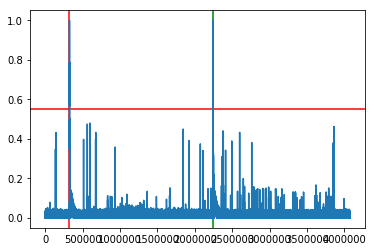

0:00:00.515090
107 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/08/15/20170908152552187_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/08/15/20170908152552187_SVAKOV-R12_raws.fits
delka zaznamu          : 21.200006783999996 s
cas prvni vzorku s GPS : 1.00567740515 s
cas 1. GPS a konec     : 20.194329378849996 s
SysCas ukladani souboru: 2017-09-08 15:25:52 s
SysCas zacatku souboru : 2017-09-08 15:25:30.799993
SysCas 1. GPS znacky   : 2017-09-08 15:25:31.805671
Korekce systémoveho čas: -1 day, 23:59:58.194329
CorCas ukladani souboru: 2017-09-08 15:25:50.194329 s
CorCas zacatku souboru : 2017-09-08 15:25:28.994322
CorCas 1. GPS znacky   : 2017-09-08 15:25:30


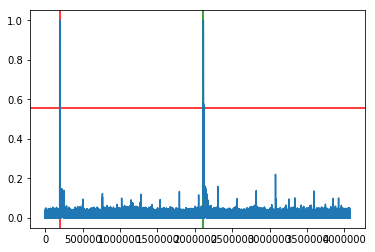

-1 day, 23:59:58.194329
108 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/08/14/20170908143601936_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/08/14/20170908143601936_SVAKOV-R12_raws.fits
delka zaznamu          : 10.600003391999998 s
cas prvni vzorku s GPS : 2.93536552265 s
cas 1. GPS a konec     : 7.664637869349997 s
SysCas ukladani souboru: 2017-09-08 14:36:01 s
SysCas zacatku souboru : 2017-09-08 14:35:50.399997
SysCas 1. GPS znacky   : 2017-09-08 14:35:53.335362
Korekce systémoveho čas: -1 day, 23:59:56.664638
CorCas ukladani souboru: 2017-09-08 14:35:57.664638 s
CorCas zacatku souboru : 2017-09-08 14:35:47.064635
CorCas 1. GPS znacky   : 2017-09-08 14:35:50


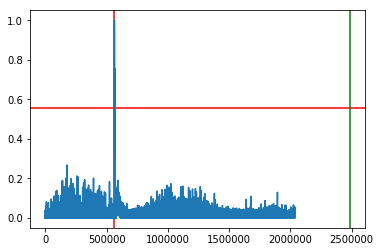

-1 day, 23:59:56.664638
109 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/08/14/20170908142505211_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/08/14/20170908142505211_SVAKOV-R12_raws.fits
delka zaznamu          : 12.00000384 s
cas prvni vzorku s GPS : 9.898544834199999 s
cas 1. GPS a konec     : 2.1014590058000007 s
SysCas ukladani souboru: 2017-09-08 14:25:05 s
SysCas zacatku souboru : 2017-09-08 14:24:52.999996
SysCas 1. GPS znacky   : 2017-09-08 14:25:02.898541
Korekce systémoveho čas: -1 day, 23:59:57.101459
CorCas ukladani souboru: 2017-09-08 14:25:02.101459 s
CorCas zacatku souboru : 2017-09-08 14:24:50.101455
CorCas 1. GPS znacky   : 2017-09-08 14:25:00


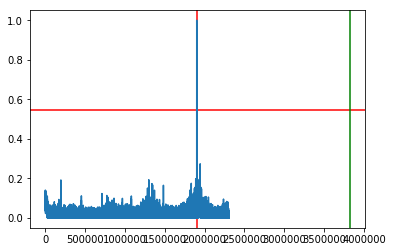

-1 day, 23:59:57.101459
110 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/08/12/20170908120825872_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/08/12/20170908120825872_SVAKOV-R12_raws.fits
delka zaznamu          : 10.600003391999998 s
cas prvni vzorku s GPS : 3.69719909977 s
cas 1. GPS a konec     : 6.902804292229998 s
SysCas ukladani souboru: 2017-09-08 12:08:25 s
SysCas zacatku souboru : 2017-09-08 12:08:14.399997
SysCas 1. GPS znacky   : 2017-09-08 12:08:18.097196
Korekce systémoveho čas: 0:00:01.902804
CorCas ukladani souboru: 2017-09-08 12:08:26.902804 s
CorCas zacatku souboru : 2017-09-08 12:08:16.302801
CorCas 1. GPS znacky   : 2017-09-08 12:08:20


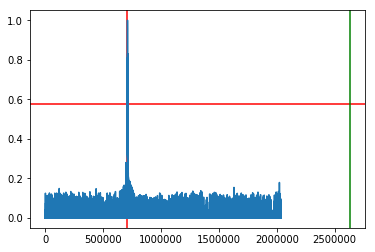

0:00:01.902804
111 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/08/10/20170908102600677_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/08/10/20170908102600677_SVAKOV-R12_raws.fits
delka zaznamu          : 34.000010880000005 s
cas prvni vzorku s GPS : 2.31764657498 s
cas 1. GPS a konec     : 31.682364305020005 s
SysCas ukladani souboru: 2017-09-08 10:26:00 s
SysCas zacatku souboru : 2017-09-08 10:25:25.999989
SysCas 1. GPS znacky   : 2017-09-08 10:25:28.317636
Korekce systémoveho čas: 0:00:01.682364
CorCas ukladani souboru: 2017-09-08 10:26:01.682364 s
CorCas zacatku souboru : 2017-09-08 10:25:27.682353
CorCas 1. GPS znacky   : 2017-09-08 10:25:30


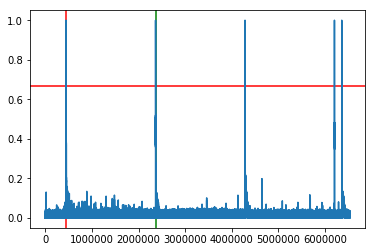

0:00:01.682364
112 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/08/10/20170908102512037_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/08/10/20170908102512037_SVAKOV-R12_raws.fits
delka zaznamu          : 10.000003199999998 s
cas prvni vzorku s GPS : 0.99069823369 s
cas 1. GPS a konec     : 9.009304966309998 s
SysCas ukladani souboru: 2017-09-08 10:25:12 s
SysCas zacatku souboru : 2017-09-08 10:25:01.999997
SysCas 1. GPS znacky   : 2017-09-08 10:25:02.990695
Korekce systémoveho čas: -1 day, 23:59:57.009305
CorCas ukladani souboru: 2017-09-08 10:25:09.009305 s
CorCas zacatku souboru : 2017-09-08 10:24:59.009302
CorCas 1. GPS znacky   : 2017-09-08 10:25:00


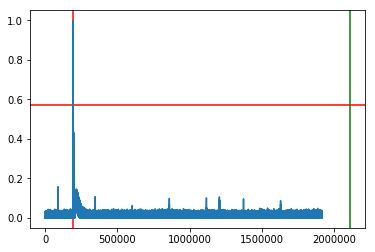

-1 day, 23:59:57.009305
113 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/08/10/20170908101246907_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/08/10/20170908101246907_SVAKOV-R12_raws.fits
delka zaznamu          : 13.200004223999999 s
cas prvni vzorku s GPS : 6.473335404799999 s
cas 1. GPS a konec     : 6.7266688191999995 s
SysCas ukladani souboru: 2017-09-08 10:12:46 s
SysCas zacatku souboru : 2017-09-08 10:12:32.799996
SysCas 1. GPS znacky   : 2017-09-08 10:12:39.273331
Korekce systémoveho čas: 0:00:00.726669
CorCas ukladani souboru: 2017-09-08 10:12:46.726669 s
CorCas zacatku souboru : 2017-09-08 10:12:33.526665
CorCas 1. GPS znacky   : 2017-09-08 10:12:40


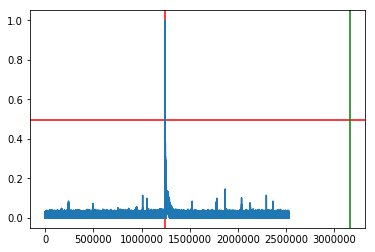

0:00:00.726669
114 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/08/08/20170908083905147_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/08/08/20170908083905147_SVAKOV-R12_raws.fits
delka zaznamu          : 30.200009663999996 s
cas prvni vzorku s GPS : 1.50381298122 s
cas 1. GPS a konec     : 28.696196682779995 s
SysCas ukladani souboru: 2017-09-08 08:39:05 s
SysCas zacatku souboru : 2017-09-08 08:38:34.799990
SysCas 1. GPS znacky   : 2017-09-08 08:38:36.303803
Korekce systémoveho čas: 0:00:03.696197
CorCas ukladani souboru: 2017-09-08 08:39:08.696197 s
CorCas zacatku souboru : 2017-09-08 08:38:38.496187
CorCas 1. GPS znacky   : 2017-09-08 08:38:40


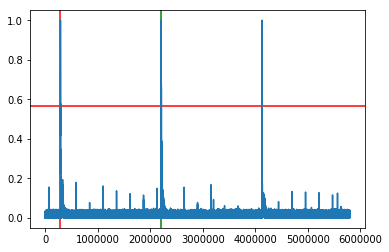

0:00:03.696197
115 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/08/08/20170908080257168_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/08/08/20170908080257168_SVAKOV-R12_raws.fits
delka zaznamu          : 11.200003584 s
cas prvni vzorku s GPS : 0.8564794407399999 s
cas 1. GPS a konec     : 10.34352414326 s
SysCas ukladani souboru: 2017-09-08 08:02:57 s
SysCas zacatku souboru : 2017-09-08 08:02:45.799996
SysCas 1. GPS znacky   : 2017-09-08 08:02:46.656476
Korekce systémoveho čas: 0:00:03.343524
CorCas ukladani souboru: 2017-09-08 08:03:00.343524 s
CorCas zacatku souboru : 2017-09-08 08:02:49.143520
CorCas 1. GPS znacky   : 2017-09-08 08:02:50


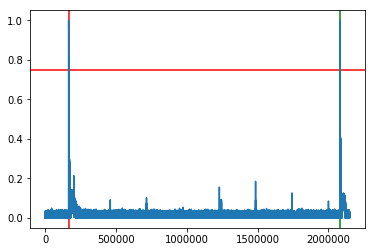

0:00:03.343524
116 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/08/05/20170908055456144_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/08/05/20170908055456144_SVAKOV-R12_raws.fits
delka zaznamu          : 9.19999252733 s
cas prvni vzorku s GPS : 1.7189745084049999 s
cas 1. GPS a konec     : 7.481018018925 s
SysCas ukladani souboru: 2017-09-08 05:54:56 s
SysCas zacatku souboru : 2017-09-08 05:54:46.800007
SysCas 1. GPS znacky   : 2017-09-08 05:54:48.518982
Korekce systémoveho čas: 0:00:01.481018
CorCas ukladani souboru: 2017-09-08 05:54:57.481018 s
CorCas zacatku souboru : 2017-09-08 05:54:48.281025
CorCas 1. GPS znacky   : 2017-09-08 05:54:50


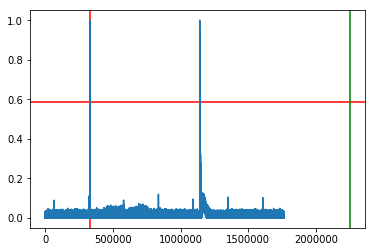

0:00:01.481018
117 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/08/05/20170908053423248_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/08/05/20170908053423248_SVAKOV-R12_raws.fits
delka zaznamu          : 12.600004032 s
cas prvni vzorku s GPS : 9.50036762345 s
cas 1. GPS a konec     : 3.0996364085499994 s
SysCas ukladani souboru: 2017-09-08 05:34:23 s
SysCas zacatku souboru : 2017-09-08 05:34:10.399996
SysCas 1. GPS znacky   : 2017-09-08 05:34:19.900364
Korekce systémoveho čas: 0:00:00.099636
CorCas ukladani souboru: 2017-09-08 05:34:23.099636 s
CorCas zacatku souboru : 2017-09-08 05:34:10.499632
CorCas 1. GPS znacky   : 2017-09-08 05:34:20


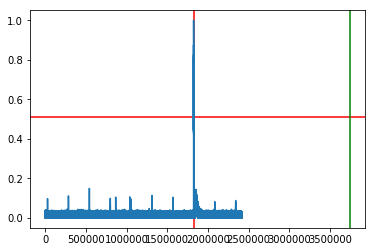

0:00:00.099636
118 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/07/22/20170907222112592_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/07/22/20170907222112592_SVAKOV-R12_raws.fits
delka zaznamu          : 9.400003008 s
cas prvni vzorku s GPS : 4.200194052395 s
cas 1. GPS a konec     : 5.1998089556050004 s
SysCas ukladani souboru: 2017-09-07 22:21:12 s
SysCas zacatku souboru : 2017-09-07 22:21:02.599997
SysCas 1. GPS znacky   : 2017-09-07 22:21:06.800191
Korekce systémoveho čas: 0:00:03.199809
CorCas ukladani souboru: 2017-09-07 22:21:15.199809 s
CorCas zacatku souboru : 2017-09-07 22:21:05.799806
CorCas 1. GPS znacky   : 2017-09-07 22:21:10


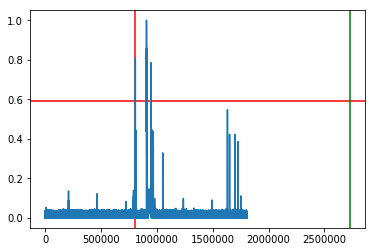

0:00:03.199809
119 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/06/15/20170906152504059_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/06/15/20170906152504059_SVAKOV-R12_raws.fits
delka zaznamu          : 10.800003455999999 s
cas prvni vzorku s GPS : 4.54002228614 s
cas 1. GPS a konec     : 6.259981169859999 s
SysCas ukladani souboru: 2017-09-06 15:25:04 s
SysCas zacatku souboru : 2017-09-06 15:24:53.199997
SysCas 1. GPS znacky   : 2017-09-06 15:24:57.740019
Korekce systémoveho čas: 0:00:02.259981
CorCas ukladani souboru: 2017-09-06 15:25:06.259981 s
CorCas zacatku souboru : 2017-09-06 15:24:55.459978
CorCas 1. GPS znacky   : 2017-09-06 15:25:00


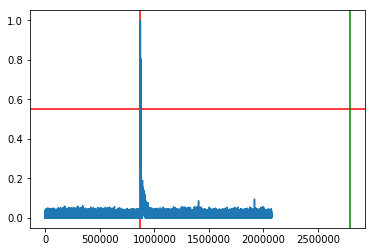

0:00:02.259981
120 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/06/10/20170906101716219_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/06/10/20170906101716219_SVAKOV-R12_raws.fits
delka zaznamu          : 15.0000048 s
cas prvni vzorku s GPS : 2.34203199945 s
cas 1. GPS a konec     : 12.657972800549999 s
SysCas ukladani souboru: 2017-09-06 10:17:16 s
SysCas zacatku souboru : 2017-09-06 10:17:00.999995
SysCas 1. GPS znacky   : 2017-09-06 10:17:03.342027
Korekce systémoveho čas: -1 day, 23:59:56.657973
CorCas ukladani souboru: 2017-09-06 10:17:12.657973 s
CorCas zacatku souboru : 2017-09-06 10:16:57.657968
CorCas 1. GPS znacky   : 2017-09-06 10:17:00


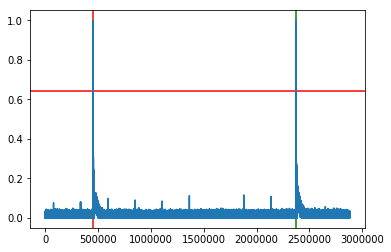

-1 day, 23:59:56.657973
121 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/06/09/20170906094717563_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/06/09/20170906094717563_SVAKOV-R12_raws.fits
delka zaznamu          : 9.800003135999999 s
cas prvni vzorku s GPS : 1.8596985117699998 s
cas 1. GPS a konec     : 7.9403046242299995 s
SysCas ukladani souboru: 2017-09-06 09:47:17 s
SysCas zacatku souboru : 2017-09-06 09:47:07.199997
SysCas 1. GPS znacky   : 2017-09-06 09:47:09.059695
Korekce systémoveho čas: 0:00:00.940305
CorCas ukladani souboru: 2017-09-06 09:47:17.940305 s
CorCas zacatku souboru : 2017-09-06 09:47:08.140302
CorCas 1. GPS znacky   : 2017-09-06 09:47:10


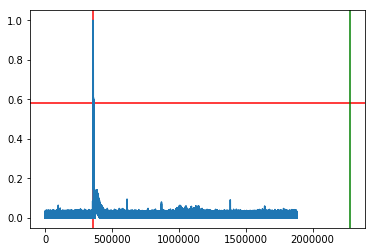

0:00:00.940305
122 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/06/08/20170906080319867_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/06/08/20170906080319867_SVAKOV-R12_raws.fits
delka zaznamu          : 10.800003455999999 s
cas prvni vzorku s GPS : 3.23999062013 s
cas 1. GPS a konec     : 7.560012835869999 s
SysCas ukladani souboru: 2017-09-06 08:03:19 s
SysCas zacatku souboru : 2017-09-06 08:03:08.199997
SysCas 1. GPS znacky   : 2017-09-06 08:03:11.439987
Korekce systémoveho čas: -1 day, 23:59:58.560013
CorCas ukladani souboru: 2017-09-06 08:03:17.560013 s
CorCas zacatku souboru : 2017-09-06 08:03:06.760010
CorCas 1. GPS znacky   : 2017-09-06 08:03:10


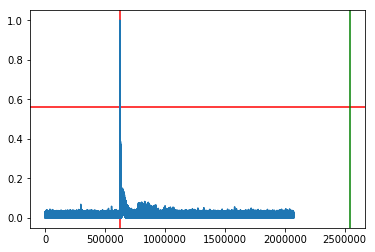

-1 day, 23:59:58.560013
123 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/06/07/20170906075337552_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/06/07/20170906075337552_SVAKOV-R12_raws.fits
delka zaznamu          : 24.400007807999998 s
cas prvni vzorku s GPS : 5.90282480557 s
cas 1. GPS a konec     : 18.49718300243 s
SysCas ukladani souboru: 2017-09-06 07:53:37 s
SysCas zacatku souboru : 2017-09-06 07:53:12.599992
SysCas 1. GPS znacky   : 2017-09-06 07:53:18.502817
Korekce systémoveho čas: 0:00:01.497183
CorCas ukladani souboru: 2017-09-06 07:53:38.497183 s
CorCas zacatku souboru : 2017-09-06 07:53:14.097175
CorCas 1. GPS znacky   : 2017-09-06 07:53:20


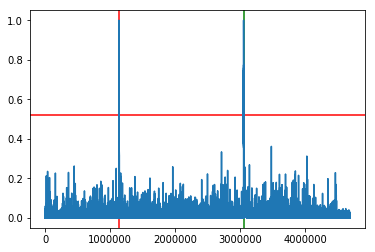

0:00:01.497183
124 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/02/12/20170902125559966_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/02/12/20170902125559966_SVAKOV-R12_raws.fits
delka zaznamu          : 10.600003391999998 s
cas prvni vzorku s GPS : 1.71185471446 s
cas 1. GPS a konec     : 8.888148677539998 s
SysCas ukladani souboru: 2017-09-02 12:55:59 s
SysCas zacatku souboru : 2017-09-02 12:55:48.399997
SysCas 1. GPS znacky   : 2017-09-02 12:55:50.111851
Korekce systémoveho čas: -1 day, 23:59:59.888149
CorCas ukladani souboru: 2017-09-02 12:55:58.888149 s
CorCas zacatku souboru : 2017-09-02 12:55:48.288146
CorCas 1. GPS znacky   : 2017-09-02 12:55:50


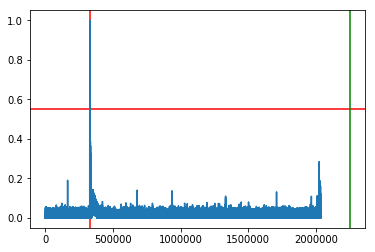

-1 day, 23:59:59.888149
125 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/02/12/20170902125258206_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/02/12/20170902125258206_SVAKOV-R12_raws.fits
delka zaznamu          : 12.00000384 s
cas prvni vzorku s GPS : 1.9703183388349998 s
cas 1. GPS a konec     : 10.029685501165 s
SysCas ukladani souboru: 2017-09-02 12:52:58 s
SysCas zacatku souboru : 2017-09-02 12:52:45.999996
SysCas 1. GPS znacky   : 2017-09-02 12:52:47.970314
Korekce systémoveho čas: 0:00:02.029686
CorCas ukladani souboru: 2017-09-02 12:53:00.029686 s
CorCas zacatku souboru : 2017-09-02 12:52:48.029682
CorCas 1. GPS znacky   : 2017-09-02 12:52:50


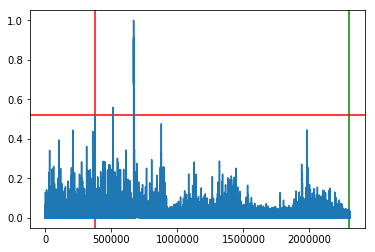

0:00:02.029686
126 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/02/12/20170902122951539_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/02/12/20170902122951539_SVAKOV-R12_raws.fits
delka zaznamu          : 10.600003391999998 s
cas prvni vzorku s GPS : 0.07219793977 s
cas 1. GPS a konec     : 10.527805452229998 s
SysCas ukladani souboru: 2017-09-02 12:29:51 s
SysCas zacatku souboru : 2017-09-02 12:29:40.399997
SysCas 1. GPS znacky   : 2017-09-02 12:29:40.472195
Korekce systémoveho čas: -1 day, 23:59:59.527805
CorCas ukladani souboru: 2017-09-02 12:29:50.527805 s
CorCas zacatku souboru : 2017-09-02 12:29:39.927802
CorCas 1. GPS znacky   : 2017-09-02 12:29:40


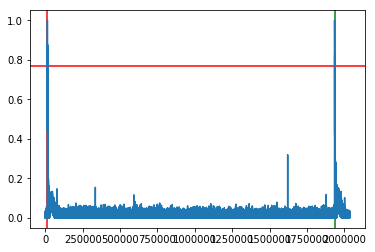

-1 day, 23:59:59.527805
127 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/02/10/20170902101820595_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/02/10/20170902101820595_SVAKOV-R12_raws.fits
delka zaznamu          : 14.600004671999999 s
cas prvni vzorku s GPS : 0.8926773689899999 s
cas 1. GPS a konec     : 13.707327303009999 s
SysCas ukladani souboru: 2017-09-02 10:18:20 s
SysCas zacatku souboru : 2017-09-02 10:18:05.399995
SysCas 1. GPS znacky   : 2017-09-02 10:18:06.292673
Korekce systémoveho čas: 0:00:03.707327
CorCas ukladani souboru: 2017-09-02 10:18:23.707327 s
CorCas zacatku souboru : 2017-09-02 10:18:09.107322
CorCas 1. GPS znacky   : 2017-09-02 10:18:10


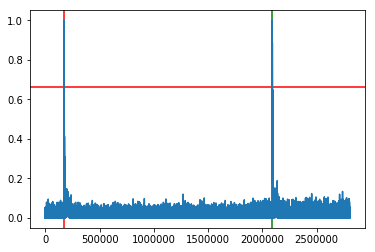

0:00:03.707327
128 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/02/08/20170902082636979_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/02/08/20170902082636979_SVAKOV-R12_raws.fits
delka zaznamu          : 20.000006399999997 s
cas prvni vzorku s GPS : 4.5268243652499995 s
cas 1. GPS a konec     : 15.473182034749996 s
SysCas ukladani souboru: 2017-09-02 08:26:36 s
SysCas zacatku souboru : 2017-09-02 08:26:15.999994
SysCas 1. GPS znacky   : 2017-09-02 08:26:20.526818
Korekce systémoveho čas: -1 day, 23:59:59.473182
CorCas ukladani souboru: 2017-09-02 08:26:35.473182 s
CorCas zacatku souboru : 2017-09-02 08:26:15.473176
CorCas 1. GPS znacky   : 2017-09-02 08:26:20


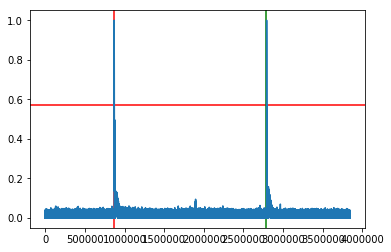

-1 day, 23:59:59.473182
129 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/02/08/20170902080312392_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/02/08/20170902080312392_SVAKOV-R12_raws.fits
delka zaznamu          : 16.200005184 s
cas prvni vzorku s GPS : 9.13358625608 s
cas 1. GPS a konec     : 7.066418927919999 s
SysCas ukladani souboru: 2017-09-02 08:03:12 s
SysCas zacatku souboru : 2017-09-02 08:02:55.799995
SysCas 1. GPS znacky   : 2017-09-02 08:03:04.933581
Korekce systémoveho čas: -1 day, 23:59:55.066419
CorCas ukladani souboru: 2017-09-02 08:03:07.066419 s
CorCas zacatku souboru : 2017-09-02 08:02:50.866414
CorCas 1. GPS znacky   : 2017-09-02 08:03:00


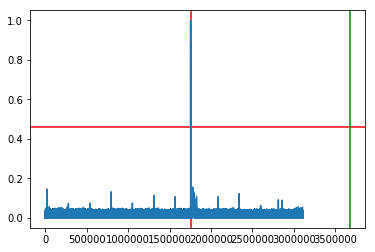

-1 day, 23:59:55.066419
130 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/02/07/20170902074629214_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/02/07/20170902074629214_SVAKOV-R12_raws.fits
delka zaznamu          : 13.800004416 s
cas prvni vzorku s GPS : 2.36899034141 s
cas 1. GPS a konec     : 11.43101407459 s
SysCas ukladani souboru: 2017-09-02 07:46:29 s
SysCas zacatku souboru : 2017-09-02 07:46:15.199996
SysCas 1. GPS znacky   : 2017-09-02 07:46:17.568986
Korekce systémoveho čas: 0:00:02.431014
CorCas ukladani souboru: 2017-09-02 07:46:31.431014 s
CorCas zacatku souboru : 2017-09-02 07:46:17.631010
CorCas 1. GPS znacky   : 2017-09-02 07:46:20


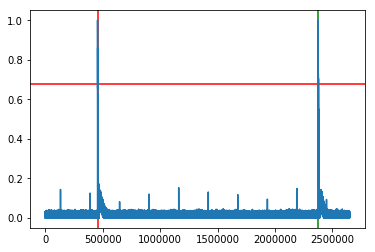

0:00:02.431014
131 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/02/06/20170902063733960_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/02/06/20170902063733960_SVAKOV-R12_raws.fits
delka zaznamu          : 14.00000448 s
cas prvni vzorku s GPS : 7.666273286539999 s
cas 1. GPS a konec     : 6.33373119346 s
SysCas ukladani souboru: 2017-09-02 06:37:33 s
SysCas zacatku souboru : 2017-09-02 06:37:18.999996
SysCas 1. GPS znacky   : 2017-09-02 06:37:26.666269
Korekce systémoveho čas: 0:00:03.333731
CorCas ukladani souboru: 2017-09-02 06:37:36.333731 s
CorCas zacatku souboru : 2017-09-02 06:37:22.333727
CorCas 1. GPS znacky   : 2017-09-02 06:37:30


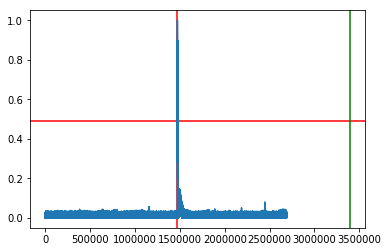

0:00:03.333731
132 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/02/06/20170902062919368_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/09/02/06/20170902062919368_SVAKOV-R12_raws.fits
delka zaznamu          : 24.800007935999997 s
cas prvni vzorku s GPS : 2.2706257265999996 s
cas 1. GPS a konec     : 22.529382209399998 s
SysCas ukladani souboru: 2017-09-02 06:29:19 s
SysCas zacatku souboru : 2017-09-02 06:28:54.199992
SysCas 1. GPS znacky   : 2017-09-02 06:28:56.470618
Korekce systémoveho čas: 0:00:03.529382
CorCas ukladani souboru: 2017-09-02 06:29:22.529382 s
CorCas zacatku souboru : 2017-09-02 06:28:57.729374
CorCas 1. GPS znacky   : 2017-09-02 06:29:00


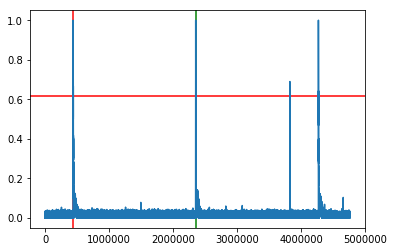

0:00:03.529382
133 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/2017/09/01/15/20170901150923550_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/2017/09/01/15/20170901150923550_SVAKOV-R12_raws.fits
delka zaznamu          : 13.800004416 s
cas prvni vzorku s GPS : 1.27965665949 s
cas 1. GPS a konec     : 12.52034775651 s
SysCas ukladani souboru: 2017-09-01 15:09:23 s
SysCas zacatku souboru : 2017-09-01 15:09:09.199996
SysCas 1. GPS znacky   : 2017-09-01 15:09:10.479652
Korekce systémoveho čas: -1 day, 23:59:59.520348
CorCas ukladani souboru: 2017-09-01 15:09:22.520348 s
CorCas zacatku souboru : 2017-09-01 15:09:08.720344
CorCas 1. GPS znacky   : 2017-09-01 15:09:10


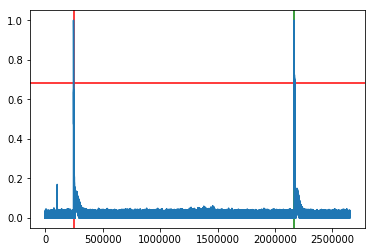

-1 day, 23:59:59.520348
134 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/2017/09/01/11/20170901112658270_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/2017/09/01/11/20170901112658270_SVAKOV-R12_raws.fits
delka zaznamu          : 23.000007359999998 s
cas prvni vzorku s GPS : 5.94151231795 s
cas 1. GPS a konec     : 17.058495042049998 s
SysCas ukladani souboru: 2017-09-01 11:26:58 s
SysCas zacatku souboru : 2017-09-01 11:26:34.999993
SysCas 1. GPS znacky   : 2017-09-01 11:26:40.941505
Korekce systémoveho čas: -1 day, 23:59:59.058495
CorCas ukladani souboru: 2017-09-01 11:26:57.058495 s
CorCas zacatku souboru : 2017-09-01 11:26:34.058488
CorCas 1. GPS znacky   : 2017-09-01 11:26:40


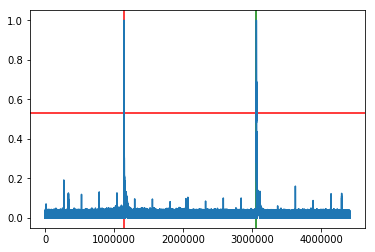

-1 day, 23:59:59.058495
135 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/2017/09/01/06/20170901065253854_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/2017/09/01/06/20170901065253854_SVAKOV-R12_raws.fits
delka zaznamu          : 11.600003712 s
cas prvni vzorku s GPS : 9.54306555378 s
cas 1. GPS a konec     : 2.0569381582199995 s
SysCas ukladani souboru: 2017-09-01 06:52:53 s
SysCas zacatku souboru : 2017-09-01 06:52:41.399996
SysCas 1. GPS znacky   : 2017-09-01 06:52:50.943062
Korekce systémoveho čas: -1 day, 23:59:59.056938
CorCas ukladani souboru: 2017-09-01 06:52:52.056938 s
CorCas zacatku souboru : 2017-09-01 06:52:40.456934
CorCas 1. GPS znacky   : 2017-09-01 06:52:50


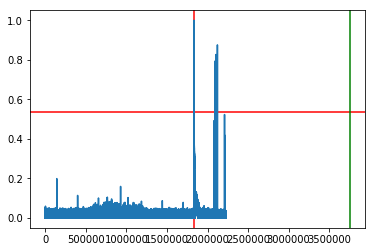

-1 day, 23:59:59.056938
136 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/2017/09/01/06/20170901062406536_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/2017/09/01/06/20170901062406536_SVAKOV-R12_raws.fits
delka zaznamu          : 9.19999252733 s
cas prvni vzorku s GPS : 6.755700078489999 s
cas 1. GPS a konec     : 2.4442924488400006 s
SysCas ukladani souboru: 2017-09-01 06:24:06 s
SysCas zacatku souboru : 2017-09-01 06:23:56.800007
SysCas 1. GPS znacky   : 2017-09-01 06:24:03.555708
Korekce systémoveho čas: -1 day, 23:59:56.444292
CorCas ukladani souboru: 2017-09-01 06:24:02.444292 s
CorCas zacatku souboru : 2017-09-01 06:23:53.244299
CorCas 1. GPS znacky   : 2017-09-01 06:24:00


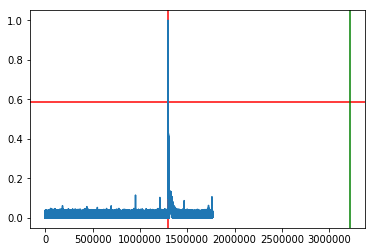

-1 day, 23:59:56.444292


In [91]:

for i, bolid in enumerate(bolids.result):
    print(i,"==================================")
    print("snapshot:", bolid['url_file_js9'])
    bolids.result[i]['time_calib']=timeCalibration(bolid['url_file_raw'], debug=True)
    try:
        print(bolids.result[i]['time_calib']['cor_error'])
    except Exception as e:
        print(e)
    

# Filtr nevyhovujících dat

Protože v některých datech nemusí být dobře detekovatelná GPS značka, je zde možné tyto soubory ručně vyřadit. A to tím, že odkomentujete druhý řádek následující buňky a do seznamu napíšete čísla vyhovujících RAW souborů. (Jsou k nalezení ve výstupu předchozí buňky)

In [92]:
selected = list(range(0, len(bolids.result)))
#selected = list(range(0, 33))

remove = [21,36,44,48,83,93,96,101,109,110,116,118,123,125]
# V predchozim radku nastavte soubory, kterj chcete ze zpracovavanych vzorku vyloucit
for x in remove:
    selected.remove(x)

    
#.remove(13).remove(24).remove(29).remove(32))
#selected = [1,2,3]     #Pokud chcete vybrat konkrétní data, 
                               #odkomentujte tento řádek a vložte do něj čísla požadovaných dat

for i, bolid in enumerate(bolids.result):
    if i in selected:
        print(i, ',sysT of gps:', bolid['time_calib']['cor_1st_GPS'], ',offset:', bolid['time_calib']['cor_error'], bolid['filename'])

0 ,sysT of gps: 2017-09-15 10:50:00 ,offset: -1 day, 23:59:56.148388 20170915105013392_SVAKOV-R12_met.fits
1 ,sysT of gps: 2017-09-15 10:10:40 ,offset: -1 day, 23:59:57.206526 20170915101059387_SVAKOV-R12_met.fits
2 ,sysT of gps: 2017-09-15 08:25:50 ,offset: 0:00:01.216688 20170915082551547_SVAKOV-R12_met.fits
3 ,sysT of gps: 2017-09-15 06:51:30 ,offset: -1 day, 23:59:58.901764 20170915065215589_SVAKOV-R12_met.fits
4 ,sysT of gps: 2017-09-15 05:17:10 ,offset: 0:00:04.406096 20170915051712421_SVAKOV-R12_met.fits
5 ,sysT of gps: 2017-09-15 04:57:10 ,offset: -1 day, 23:59:58.699937 20170915045815611_SVAKOV-R12_met.fits
6 ,sysT of gps: 2017-09-15 04:33:00 ,offset: -1 day, 23:59:57.476972 20170915043312379_SVAKOV-R12_met.fits
7 ,sysT of gps: 2017-09-15 00:17:50 ,offset: -1 day, 23:59:58.142830 20170915001758117_SVAKOV-R12_met.fits
8 ,sysT of gps: 2017-09-14 21:30:50 ,offset: -1 day, 23:59:59.176345 20170914213054352_SVAKOV-R12_met.fits
9 ,sysT of gps: 2017-09-14 14:06:40 ,offset: -1 day, 23

In [110]:
arrayX = []
arrayY = []
for i, bolid in enumerate(bolids.result):
    try:
        offset = abs(bolid['time_calib']['cor_error']).microseconds/1000000 + abs(bolid['time_calib']['cor_error']).seconds
        if bolid['time_calib']['cor_error'] < datetime.timedelta(seconds=0): offset = -offset
        print(i, bolid['time_calib']['sys_file_end'].timestamp(), offset, bolid['duration'])
        if bolid['duration']>0:
            arrayX.append(bolid['time_calib']['sys_file_end'].timestamp())
            #arrayX.append(bolid['duration'])
            arrayY.append(offset)
    except Exception as e: pass #print(e)
    

0 1505465413.0 -3.8516120000000003 4.94933
1 1505463059.0 -2.793474 15.5307
2 1505456751.0 1.216688 4.43733
3 1505451135.0 -1.098236 39.2533
4 1505445432.0 4.406096 4.096
5 1505444295.0 -1.300063 50.8587
6 1505442792.0 -2.523028 8.02133
7 1505427478.0 -1.85717 7.33867
8 1505417454.0 -0.823655 4.096
9 1505390813.0 -4.7402370000000005 5.46133
10 1505383017.0 1.481346 5.632
11 1505375990.0 -3.224789 5.12
12 1505360525.0 -3.422017 12.288
13 1505354921.0 3.812647 4.26667
14 1505352454.0 3.775252 5.80267
15 1505345397.0 -1.209123 4.608
16 1505344845.0 -0.519634 5.632
17 1505343948.0 -2.178404 4.26667
18 1505341221.0 0.814757 16.5547
19 1505331476.0 0.278033 4.096
20 1505308800.0 -2.277435 4.43733
21 1505278829.0 1.000005 4.43733
22 1505276653.0 3.994922 16.896
23 1505272933.0 -0.253871 15.36
24 1505269455.0 -2.555843 5.97333
25 1505253732.0 -1.970559 4.94933
26 1505217731.0 2.758407 4.43733
27 1505216734.0 2.008557 11.9467
28 1505212221.0 -1.3092679999999999 8.704
29 1505207855.0 4.302534 4.

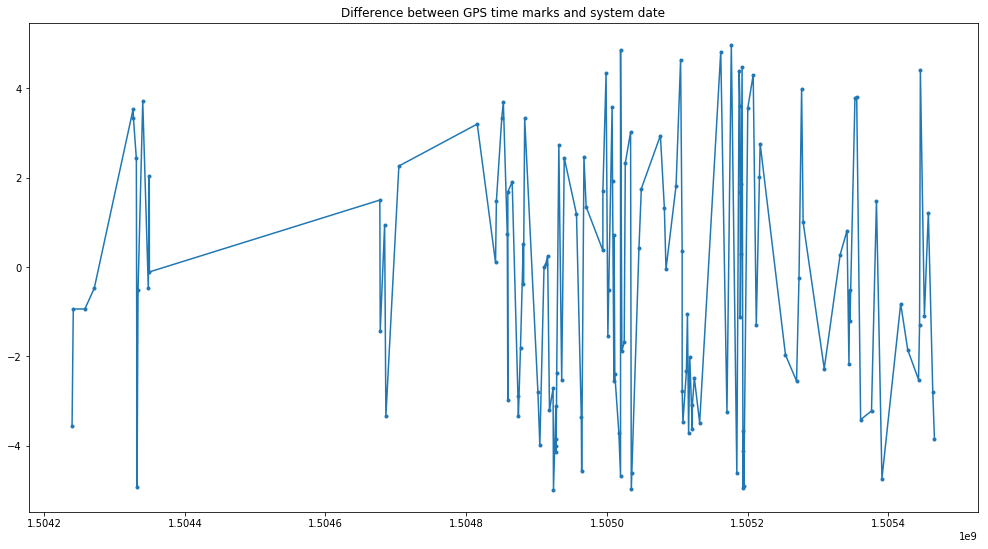

In [112]:
%matplotlib inline
plt.figure(figsize=(17, 9))
plt.title("Difference between GPS time marks and system date")
plt.plot(arrayX, arrayY, '.-')
plt.show()
